# Generating Slides for Swedish and US EPL Presentation

- Part 0: Importing Packages and Data and Cleaning Data
- Part 1: Timeseries Plots
- Part 2: Comparing EPL Indeces in OECD Countries
- Part 3: EPL Index Subcategories for the US and Sweden
- Part 4: ILO EPL Strictness Indeces
- Part 5: Unemployment Measures and EPL

## Part 0: Importing Packages and Data and Cleaning Data

In [ ]:
!pip install adjustText

In [4]:
#importing packages
import math
import scipy.stats as stats
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import statsmodels.api as sm
import warnings
from google.colab import drive
from adjustText import adjust_text
from scipy.stats import linregress
from matplotlib.lines import Line2D

In [5]:
#configuring notebook
matplotlib.rcParams['mathtext.fontset'] = 'stix'        # LaTeX font
matplotlib.rcParams['font.family'] = 'STIXGeneral'
%matplotlib inline                                      
%config InlineBackend.figure_format='retina'             
warnings.filterwarnings("ignore")                        # Ignore warnings

In [6]:
drive.mount('/content/drive')                           # Mounting Google Drive Data

Mounted at /content/drive


In [34]:
# Loading data
base_path = "/content/drive/MyDrive/Cristian/epl_analysis_sweden_us/data/"      # Setting path to directory with data

# Loading four EPL datasets from the OECD
dfs = []
for df_name in ["epl_regular_contract", "epl_temp_contract", "epl_individual", "epl_collective"]:
    dfs.append(pd.read_csv(base_path + df_name + '.csv'))
df = pd.concat(dfs)

# Selecting relevant columns and renaming them
df = df[["COUNTRY", "Country", "SERIES", "Time", "Value"]]
df.columns = ["iso", "country", "measure", "year", "value"]
df['country'] = df['country'].replace('Türkiye', 'Turkey')

In [35]:
# Creating dicitonary defining different measures of EPL
keys = df["measure"].unique()
key_descriptions = {
    'EPRC': 'EPL Strictness for Regular Contracts',
    'EPT': 'EPL Strictness for Temporary Contracts',
    'EPR': 'EPL Strictness for Individual Dismissals',
    'EPC': 'EPL Strictness for Collective Dismissals'
}

key_versions = {'V1': '(Version 1)', 'V2': '(Version 2)', 'V3': '(Version 3)', 'V4': '(Version 4)'}

key_dict = {}
for key in keys:
    key_split = key.split('_')
    key_base = key_split[0]
    key_version = key_split[1]
    description = f"{key_descriptions[key_base]}"
    key_dict[key] = description

In [36]:
# Creating boolean column that labels OECD countries (in 2019)
oecd_countries = [
    'AUS',  # Australia
    'AUT',  # Austria
    'BEL',  # Belgium
    'CAN',  # Canada
    'CHL',  # Chile
    'CZE',  # Czech Republic
    'DNK',  # Denmark
    'EST',  # Estonia
    'FIN',  # Finland
    'FRA',  # France
    'DEU',  # Germany
    'GRC',  # Greece
    'HUN',  # Hungary
    'ISL',  # Iceland
    'IRL',  # Ireland
    'ISR',  # Israel
    'ITA',  # Italy
    'JPN',  # Japan
    'KOR',  # Korea
    'LUX',  # Luxembourg
    'MEX',  # Mexico
    'NLD',  # Netherlands
    'NZL',  # New Zealand
    'NOR',  # Norway
    'POL',  # Poland
    'PRT',  # Portugal
    'SVK',  # Slovak Republic
    'SVN',  # Slovenia
    'ESP',  # Spain
    'SWE',  # Sweden
    'CHE',  # Switzerland
    'TUR',  # Turkey
    'GBR',  # United Kingdom
    'USA',  # United States
    'OECD'  # OECD Average
]

df["oecd"] = df["iso"].isin(oecd_countries)

## Part 1: Timeseries Plots


For our time series plots,  we need to select countries that are present for the entire time period 
to avoid spurious changes due to sample composition. We also need a consistent measure of EPL.
Only version 1 of each measure goes back to 1985, so we will need to use that.
We have data for all OECD countries in 1985 except for 'Iceland', 'Luxembourg', 'New Zealand', 'Turkey'.

In [37]:

countries_with_data_since_1985 = df[(df["year"] == 1985) & (df["value"].notna())]["country"].unique()
df_timeseries = df[(df["country"].isin(countries_with_data_since_1985)) & 
                   (df["measure"].isin(["EPRC_V1", "EPT_V1", "EPC_V1", "EPT_V1"]))]
df_timeseries = df_timeseries[["year", "measure", "value"]].groupby(["year", "measure"]).mean().reset_index()
df_timeseries["country"] = "OECD"

# Filter the DataFrame for the US, Sweden, and the OECD average
df_filtered = pd.concat([df, df_timeseries])
df_filtered["measure_type"] = df_filtered["measure"].str[:-3]
df_filtered = df_filtered[df_filtered['country'].isin(['United States', 'Sweden', 'OECD']) 
& (df_filtered["measure"].isin(["EPRC_V1", "EPT_V1"]))]
df_filtered = df_filtered.sort_values("country", ascending=False)

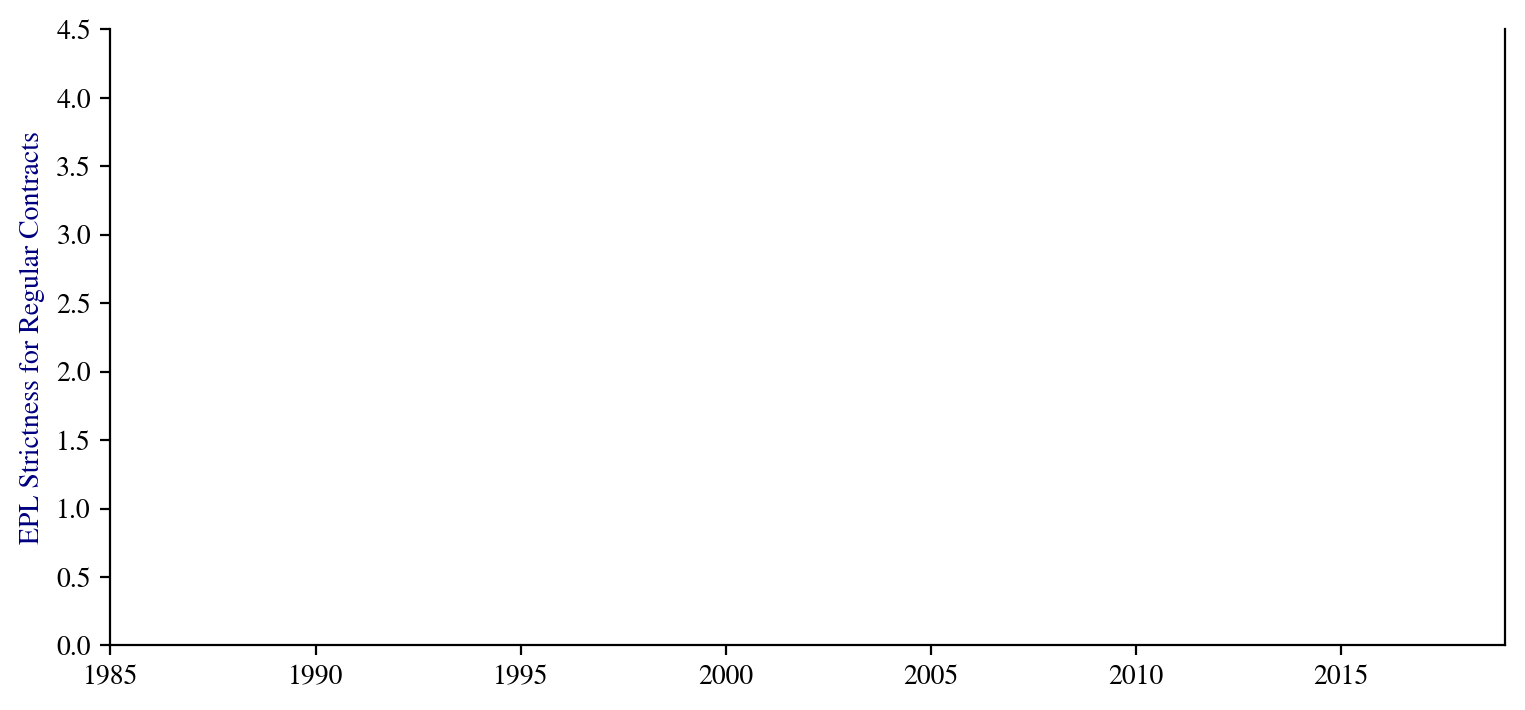

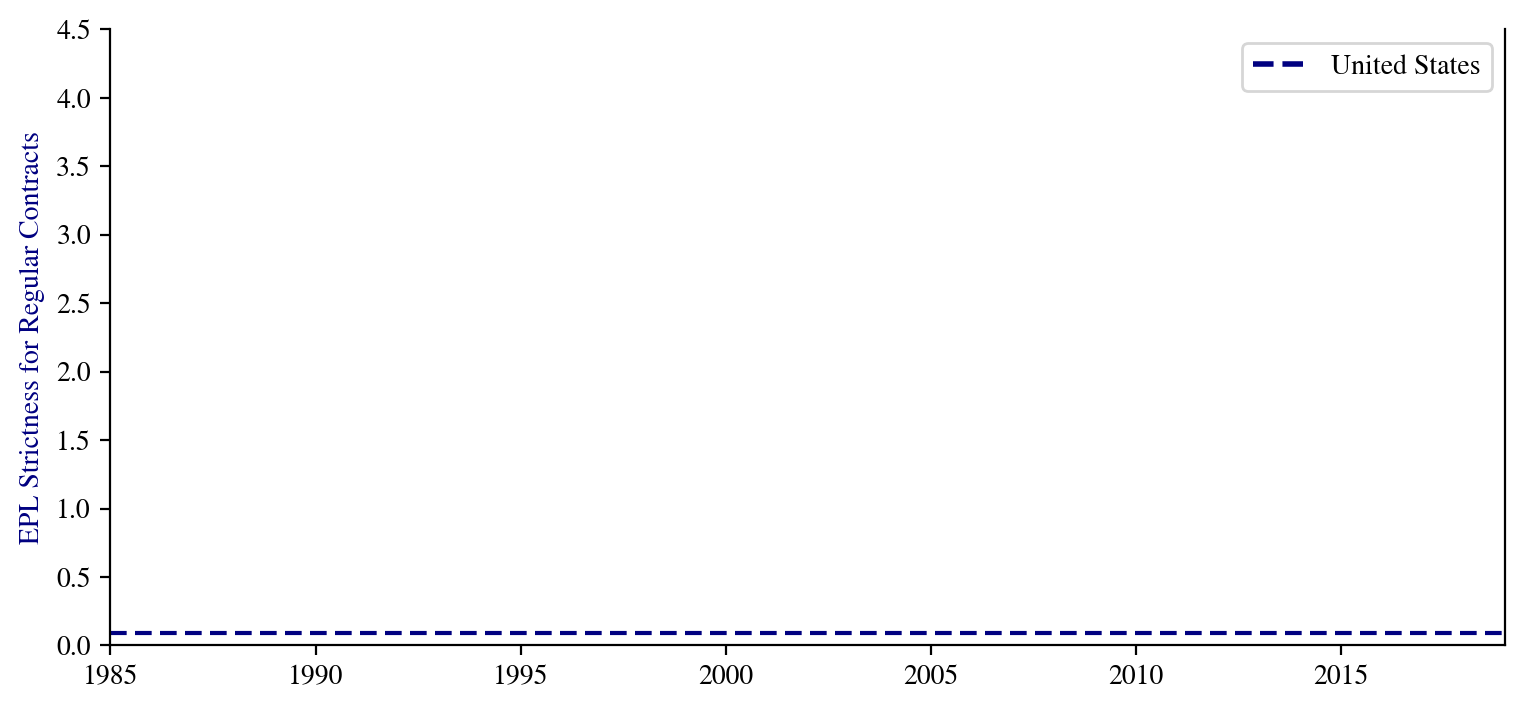

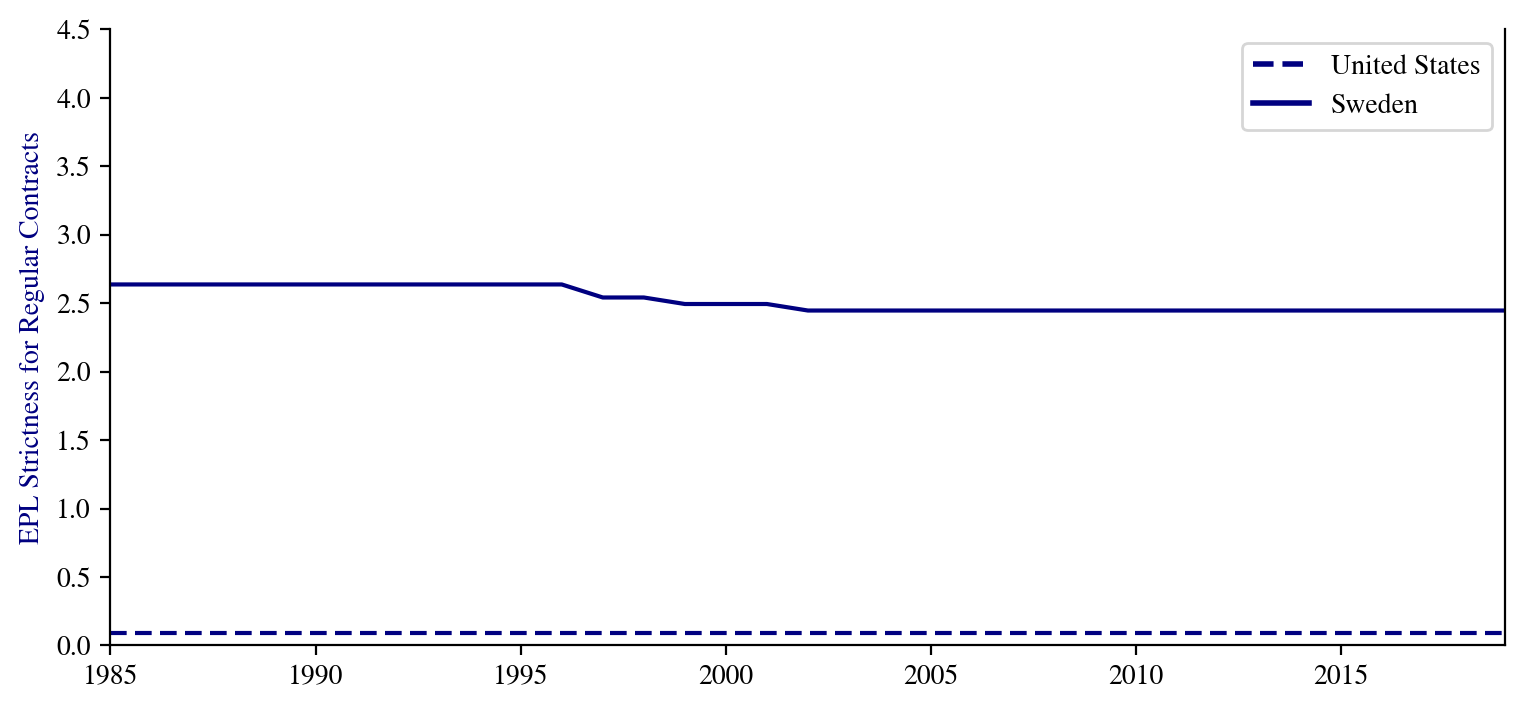

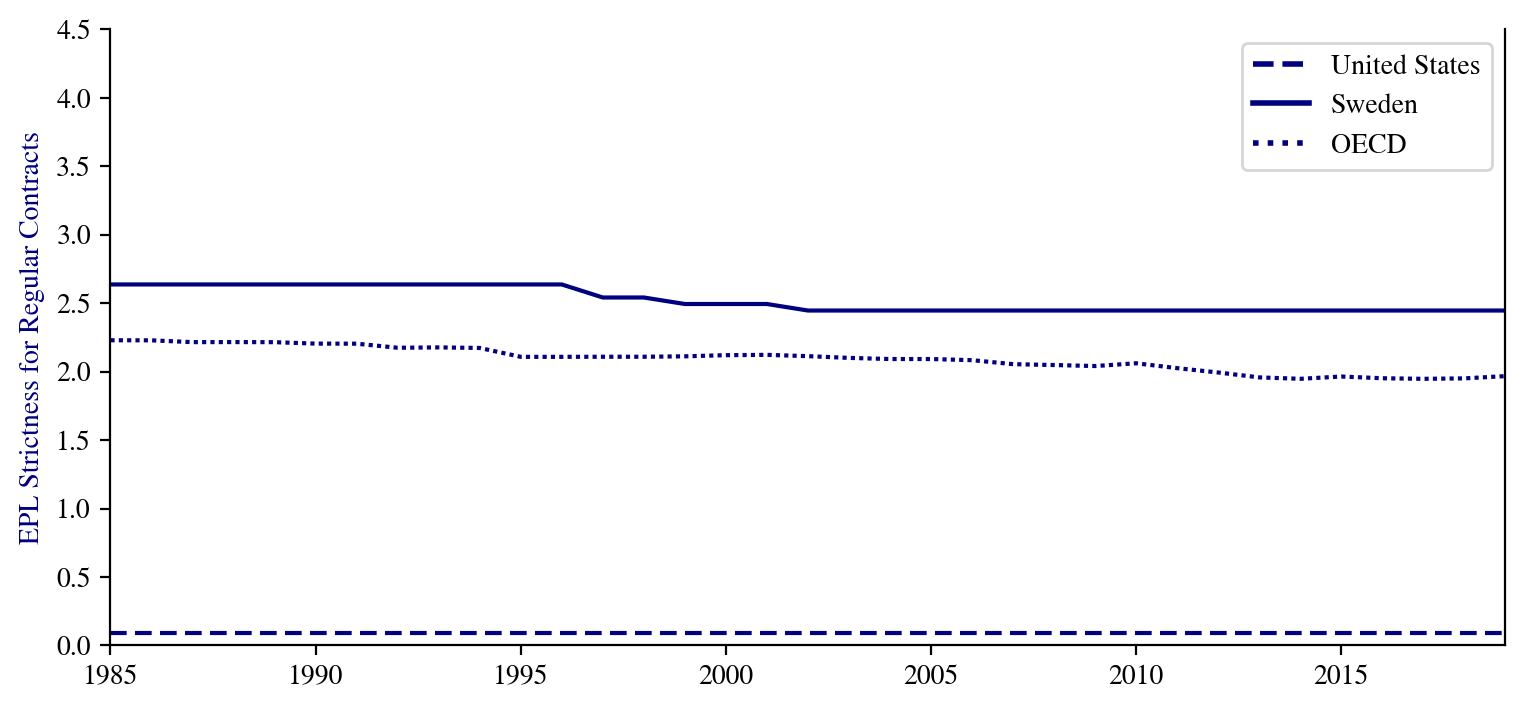

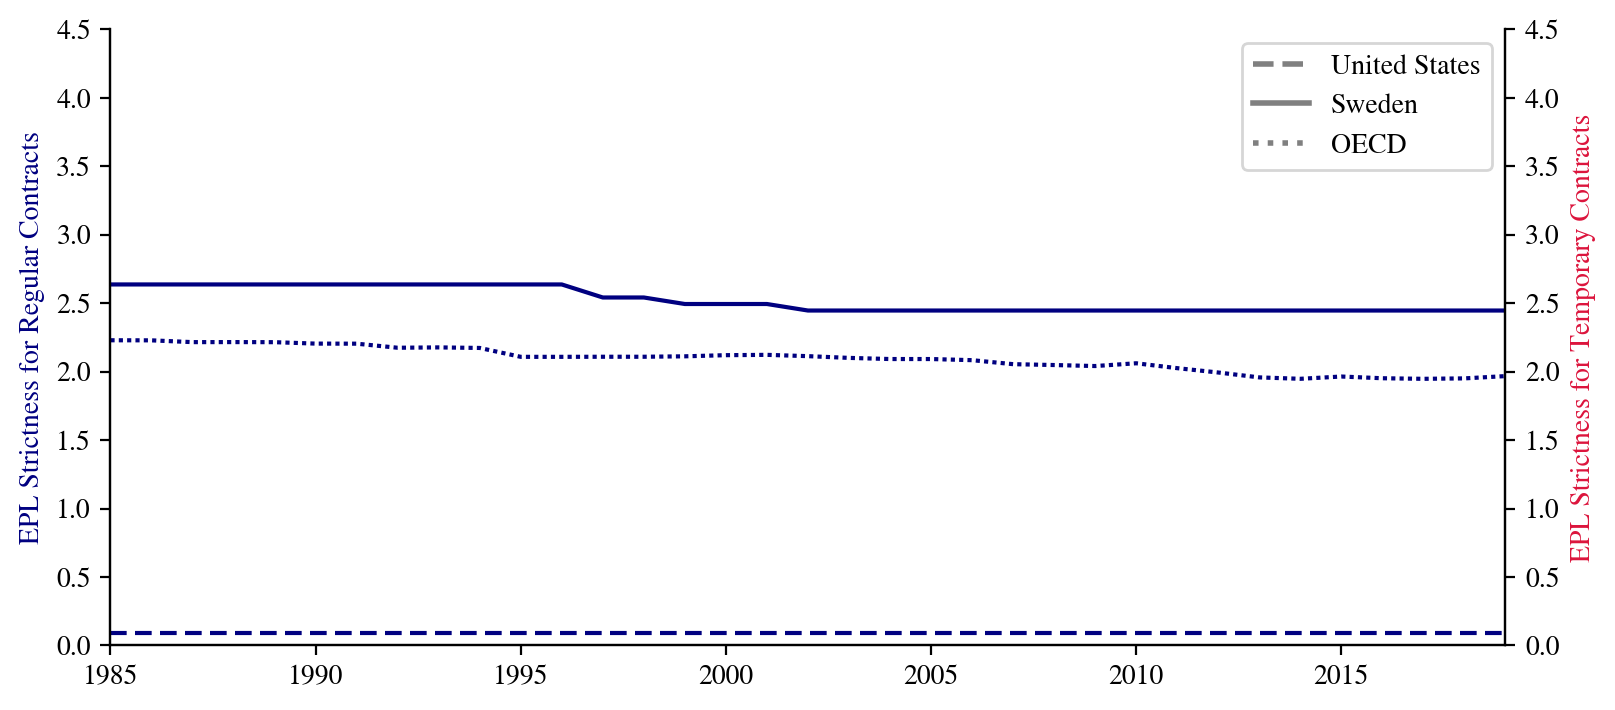

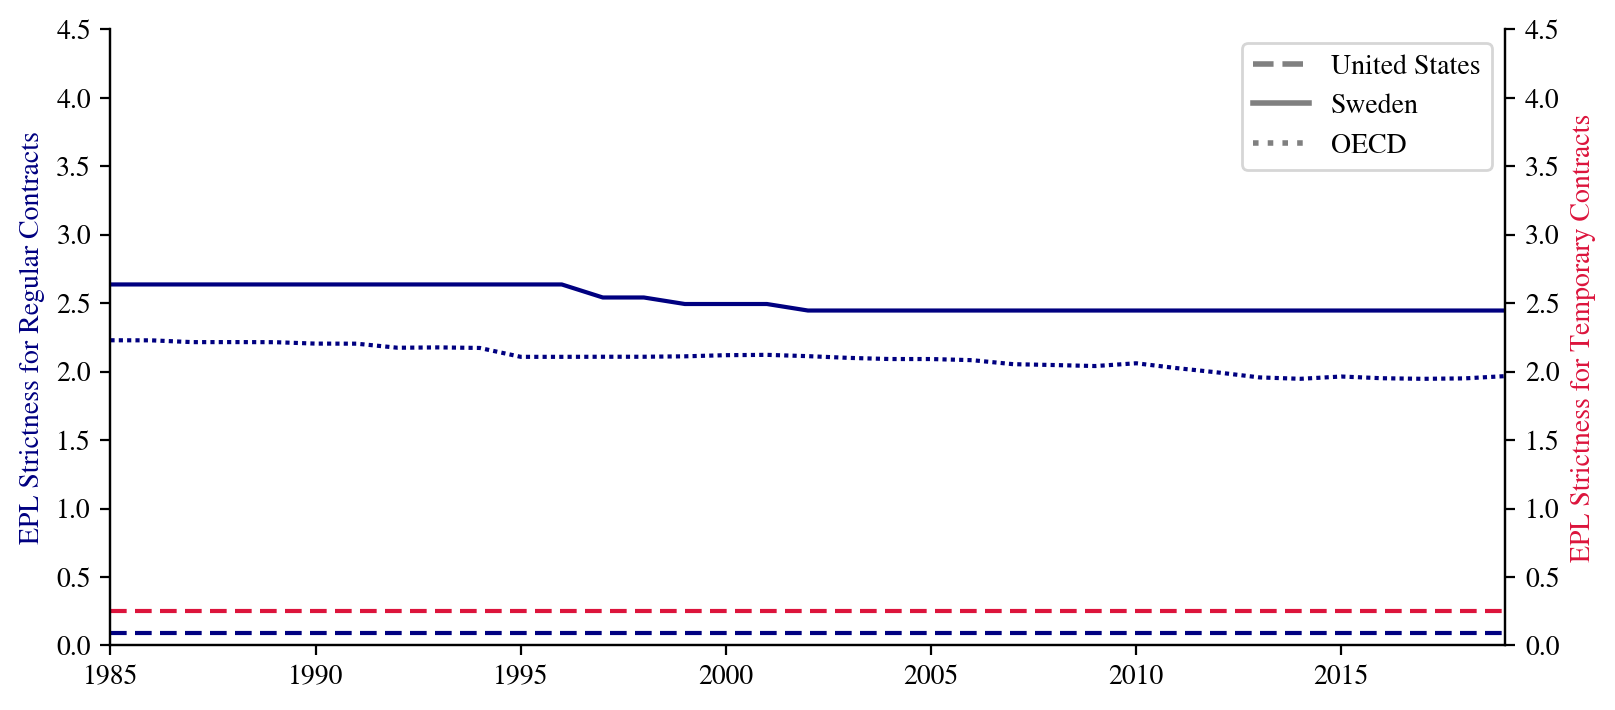

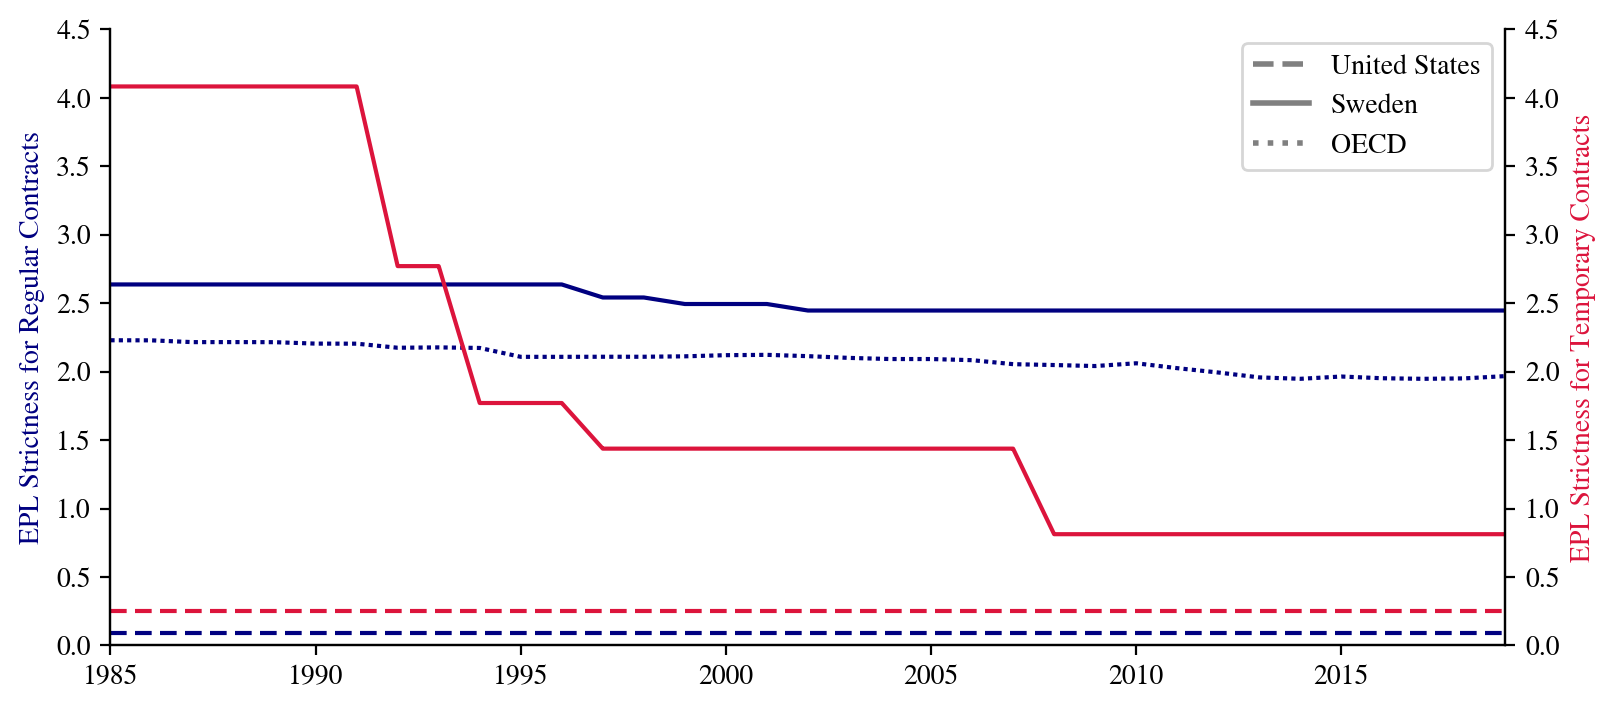

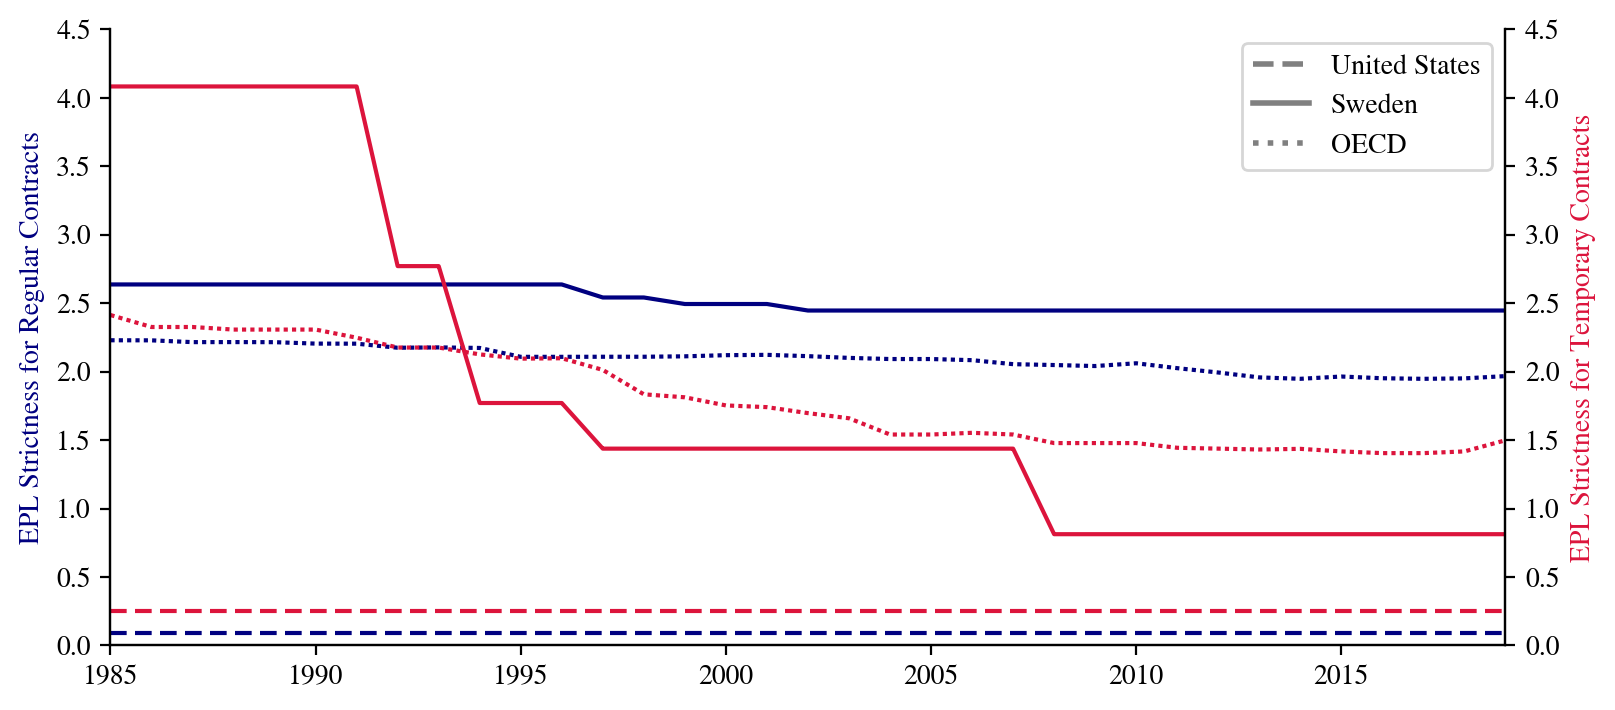

In [41]:
dash_to_style = {(4, 2):"dashed", (1, 0):"solid", (1, 1):"dotted"}

def create_plot(df, eprc_countries, ept_countries, eprc_colors, ept_colors, styles, legend_labels,legend_color='grey', right_label=False):
    """
    This function creates a plot to visualize the Employment Protection Legislation (EPL) strictness for regular and temporary contracts.
    :param df: DataFrame containing the data to plot
    :param eprc_countries: List of countries for which to display EPL strictness for regular contracts
    :param ept_countries: List of countries for which to display EPL strictness for temporary contracts
    :param eprc_colors: List of colors for the EPL strictness lines of regular contracts
    :param ept_colors: List of colors for the EPL strictness lines of temporary contracts
    :param styles: List of line styles 
    :param legend_labels: List of labels for the legend
    :param right_label: Optional; whether to display the ylabel for temporary contracts on the right. Default is False.
    """
    
    # Set up the figure and axis
    plt.figure(figsize=(9, 4))
    ax1 = plt.gca()
    
    # Determine whether to display the ylabel for temporary contracts on the right
    right_label = right_label or (ept_countries != [])
    
    # Create a twin axis for the temporary contracts data if needed
    ax2 = ax1.twinx() if right_label else ax1

    # Hide top spines and set ylabels
    ax1.spines['top'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax1.set_ylabel("EPL Strictness for Regular Contracts", color="navy")

    # Set ylabel for temporary contracts only if ax2 is not equal to ax1
    if right_label and ax2 != ax1:
        ax2.set_ylabel("EPL Strictness for Temporary Contracts", color="crimson")

    # Set y-axis limits and x-axis limits
    ax1.set_ylim(0, 4.5)
    ax2.set_ylim(0, 4.5)
    ax1.set_xlim(1985, 2019)

    # Plot EPL strictness for regular contracts
    sns.lineplot(data=df[(df['measure_type'] == 'EPRC') & (df['country'].isin(eprc_countries))],
                 x='year', y='value', hue='country', palette=eprc_colors, style='country',
                 dashes=styles, ax=ax1, legend=False)

    # Plot EPL strictness for temporary contracts if there are any countries to display
    if ept_countries:
        sns.lineplot(data=df[(df['measure_type'] == 'EPT') & (df['country'].isin(ept_countries))],
                     x='year', y='value', hue='country', palette=ept_colors, style='country',
                     dashes=styles, ax=ax1, legend=False, ci=None, )

    # Create custom legend lines based on line styles and labels
    legend_lines = [Line2D([0], [0], color=legend_color, lw=2, linestyle=style, label=label)
                    for style, label in zip([dash_to_style[x] for x in styles], legend_labels)]    
    
    # Display legend if there are any countries to display
    if ept_countries + eprc_countries != []:          
        plt.legend(handles=legend_lines, loc='upper right', title='')
    ax2.set_xlabel("")
    ax1.set_xlabel("")
    plt.show()

# Slide 1
create_plot(df_filtered, [], [], [], [], [], [], legend_color='navy')

# Slide 2
create_plot(df_filtered, ['United States'], [], ['navy'], [], [(4, 2)], ['United States'], legend_color='navy')

# Slide 3
create_plot(df_filtered, ['United States', 'Sweden'], [], ['navy'], [], [(4, 2), (1, 0)],['United States', 'Sweden'], legend_color='navy')

# Slide 4
create_plot(df_filtered, ['United States', 'Sweden', 'OECD'], [], ['navy'], [], [(4, 2), (1, 0), (1, 1)], ['United States', 'Sweden', 'OECD'], legend_color='navy')

# Slide 5
create_plot(df_filtered, ['United States', 'Sweden', 'OECD'], [], ['navy'], [], [(4, 2), (1, 0), (1, 1)], ['United States', 'Sweden', 'OECD'], right_label=True)

# Slide 6
create_plot(df_filtered, ['United States', 'Sweden', 'OECD'], ['United States'], ['navy'], ['crimson'], [(4, 2), (1, 0), (1, 1)], ['United States', 'Sweden', 'OECD'])

# Slide 7
create_plot(df_filtered, ['United States', 'Sweden', 'OECD'], ['United States', 'Sweden'], ['navy'], ['crimson'], [(4, 2), (1, 0), (1, 1)], ['United States', 'Sweden', 'OECD'])

#Slide 8
create_plot(df_filtered, ['United States', 'Sweden', 'OECD'], ['United States', 'Sweden', 'OECD'], ['navy'], ['crimson'], [(4, 2), (1, 0), (1, 1)], ['United States', 'Sweden', 'OECD'])

## Part 2: Comparing EPL Indeces in OECD Countries

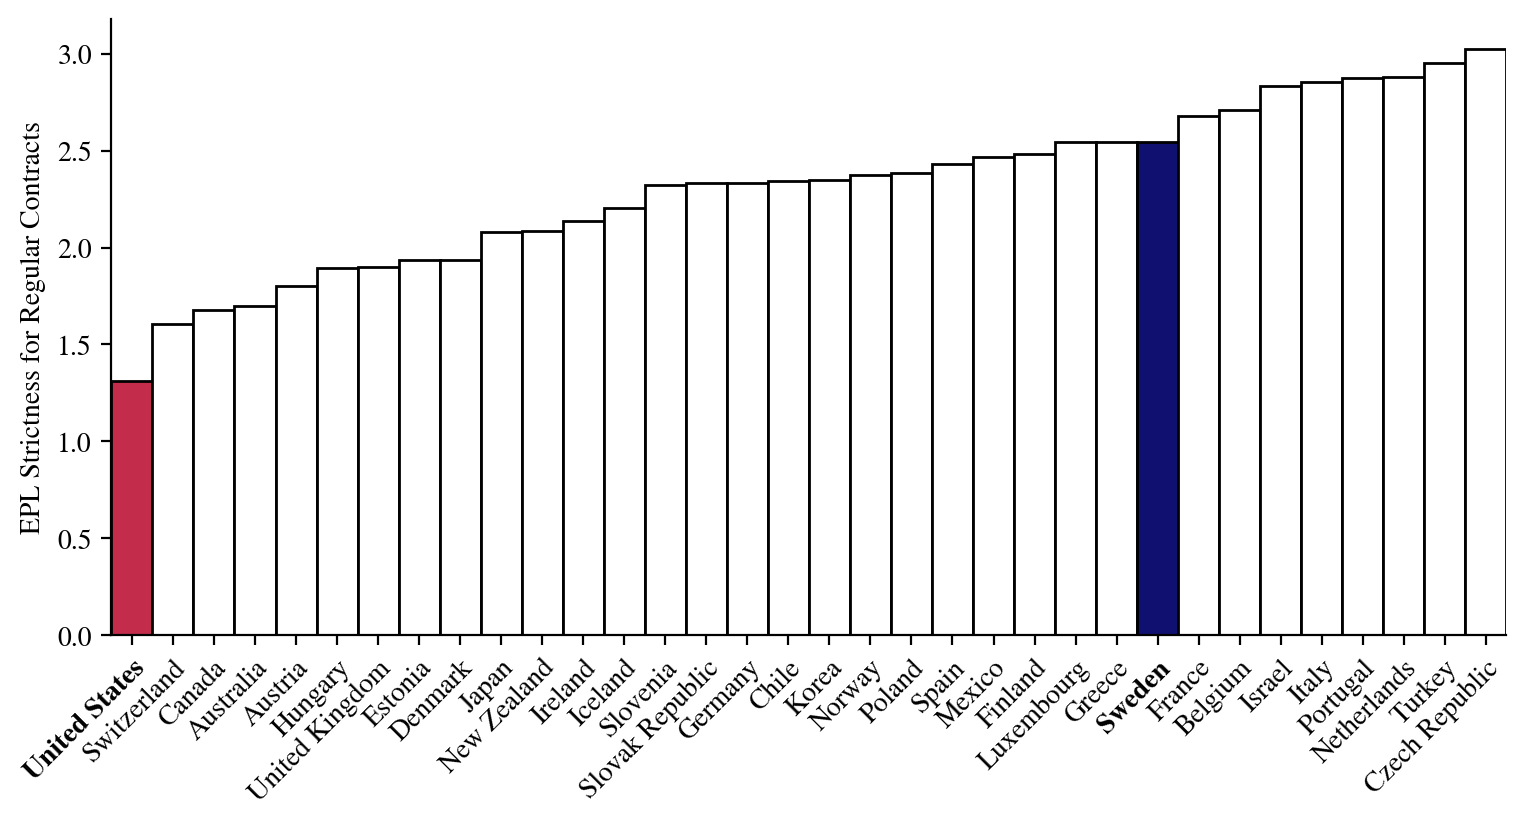

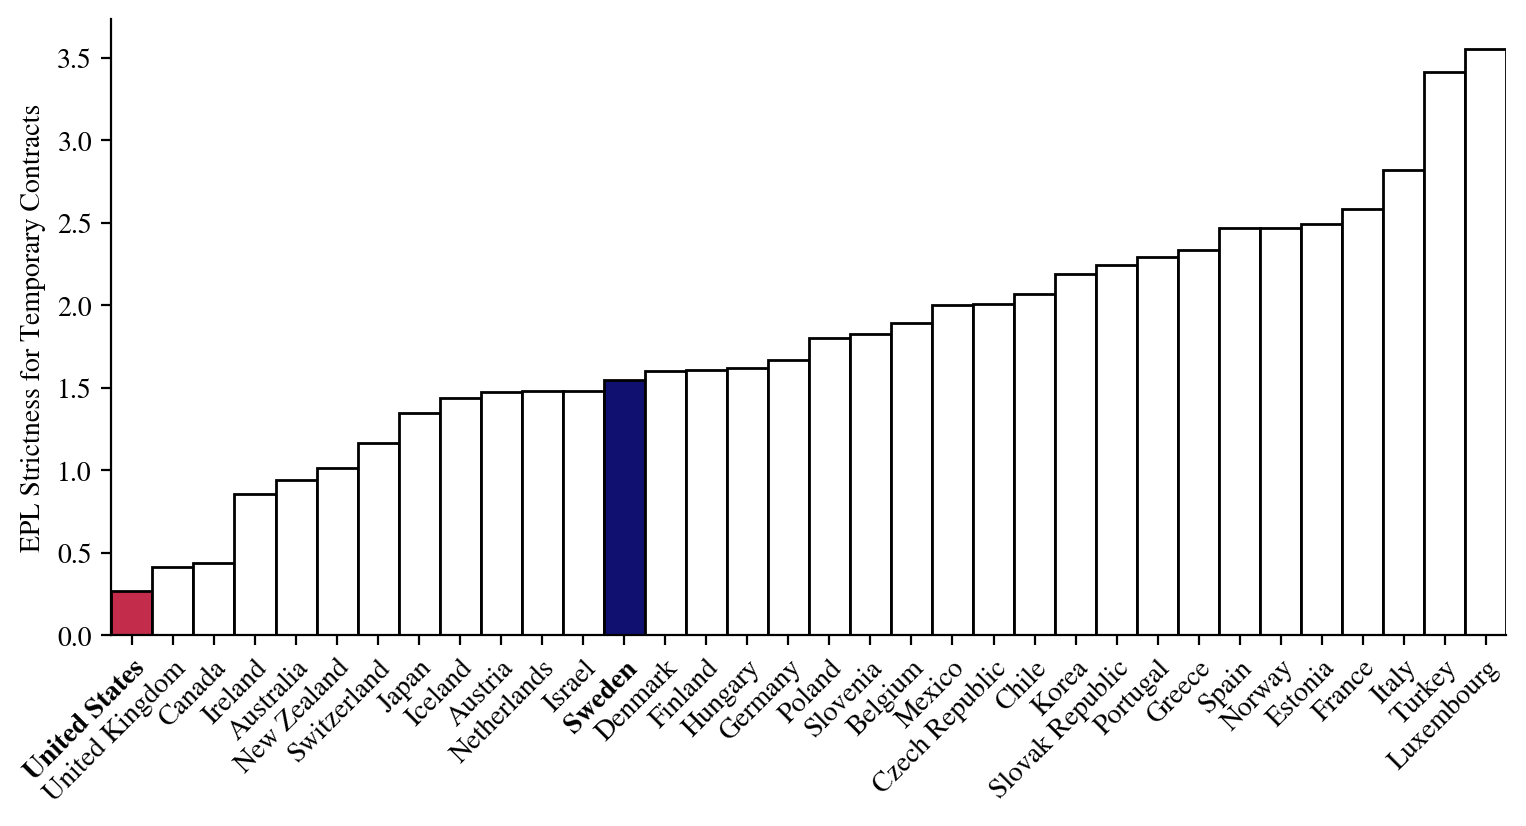

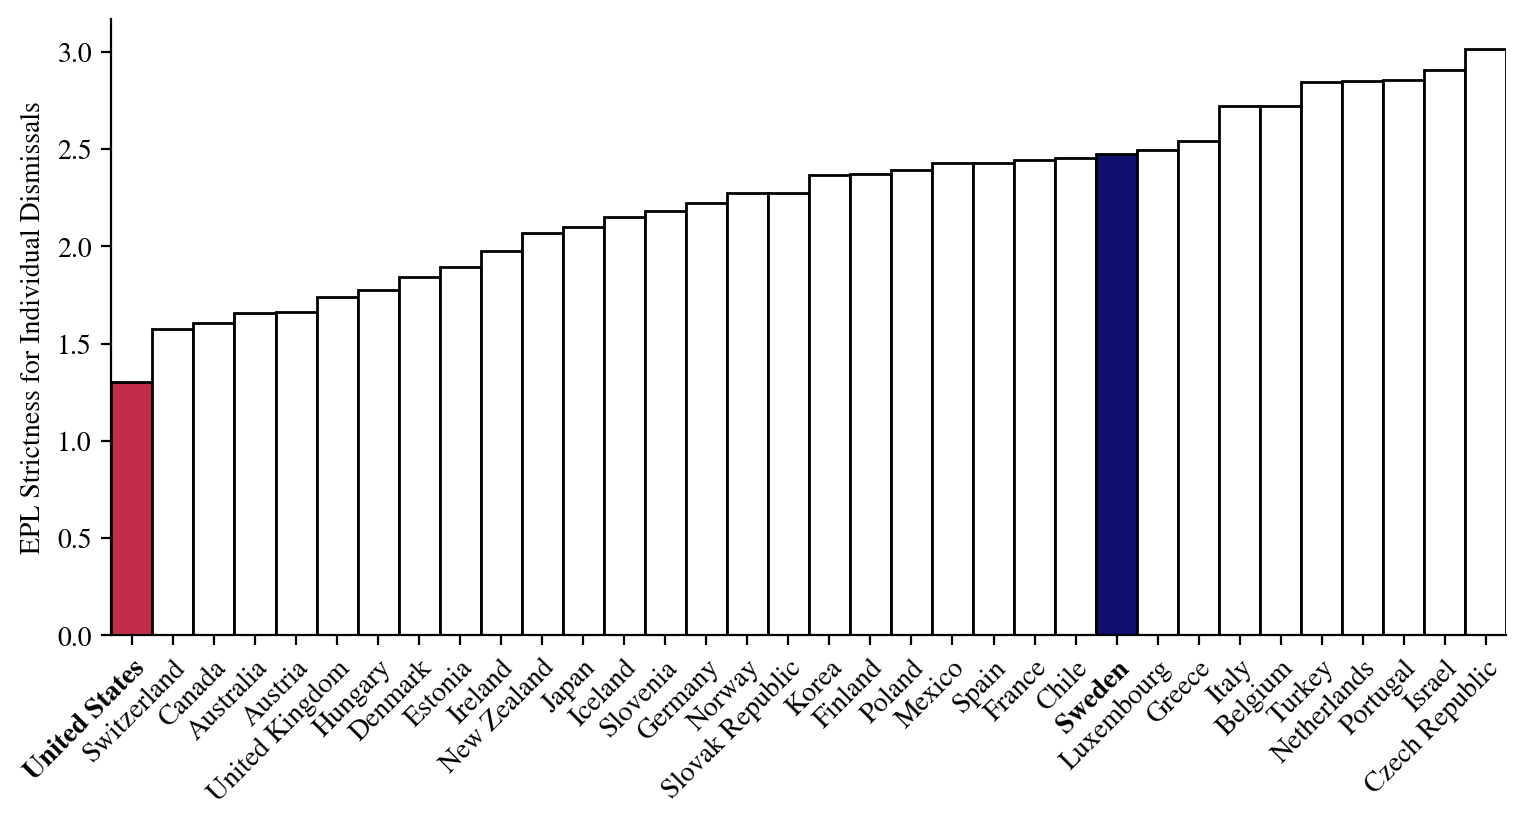

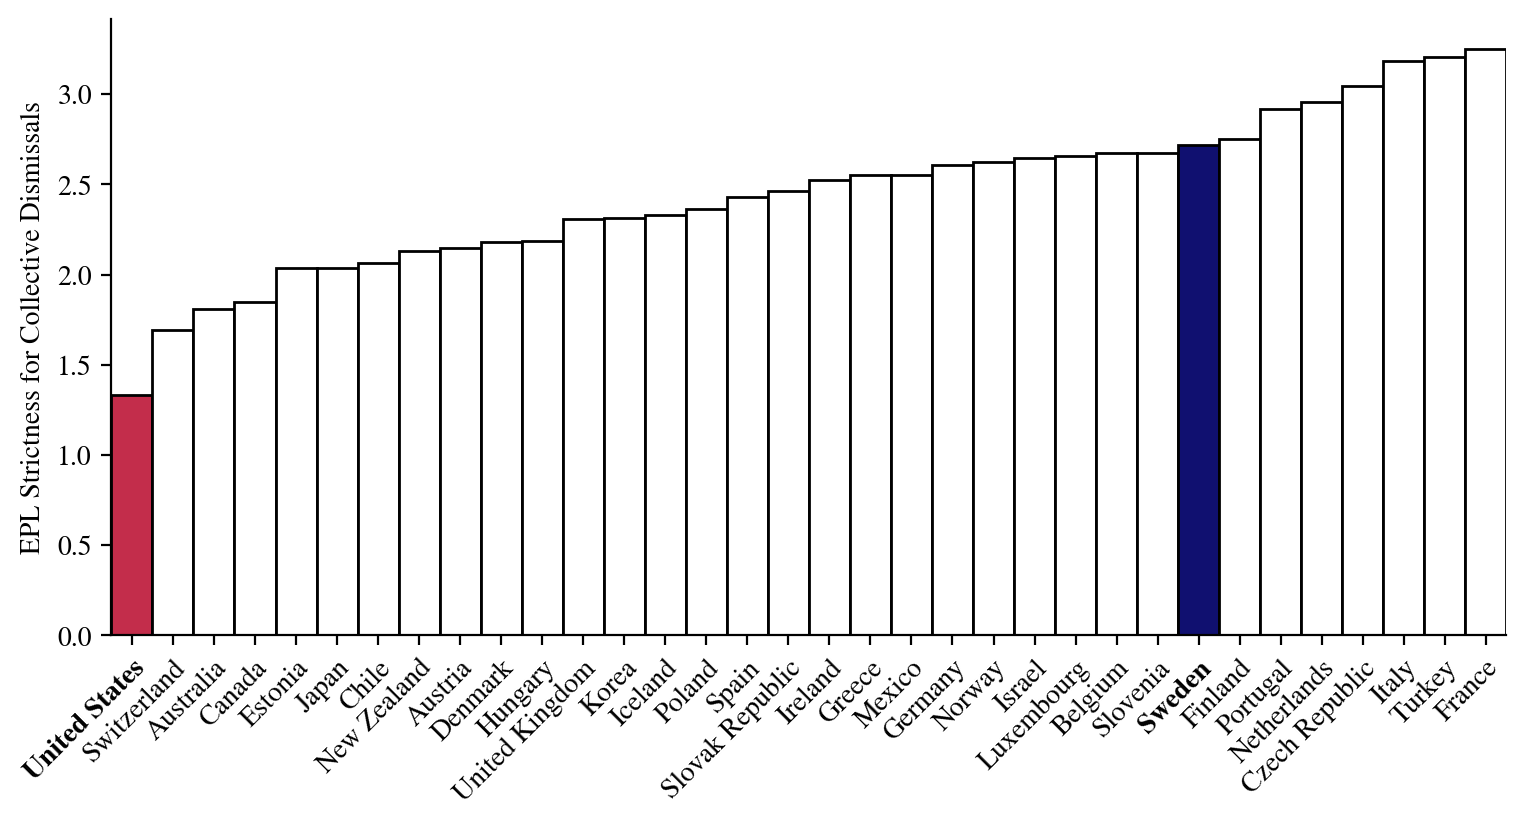

In [40]:
# Filter the DataFrame for OECD countries the year 2019, using the verson 4 (i.e. most recent) measures
df_2019 = df[(df['year'] == 2019) & (df["oecd"]) & (df["measure"].isin(["EPRC_V4", "EPT_V4", "EPR_V4", "EPC_V4"]))]

# Group by measure and create barplots
measures = df_2019['measure'].unique()

for measure in measures:
    # Filter by measure and sort by value
    df_measure = df_2019[df_2019['measure'] == measure]
    df_measure['value'] = pd.to_numeric(df_measure['value'])
    df_measure = df_measure.sort_values(by='value')

    # Get the OECD average
    oecd_avg = df_measure[df_measure['country'] == 'OECD countries']['value'].values[0]
    df_measure = df_measure[df_measure['country'] != 'OECD countries']

    # Wider plot
    plt.figure(figsize=(9, 4))
    ax = sns.barplot(data=df_measure, x='country', y='value', 
                     palette=['white' if country not in ['United States', 'Sweden'] else 'navy' if country == "Sweden" else "crimson" for country in df_measure['country']], 
                     edgecolor='black', linewidth=1, width=1)

    # Rotate x-axis labels
    plt.xticks(rotation=45, ha='right', rotation_mode='anchor')

    # Make US and Sweden labels bold
    bold_labels = ['United States', 'Sweden']
    for label in ax.get_xticklabels():
        if label.get_text() in bold_labels:
            label.set_weight('bold')

    # Remove top and right plot borders
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.xlabel('')
    plt.ylabel(key_dict[measure])
    plt.show()

## Part 3: EPL Index Subcategories for the US and Sweden

In [13]:
# Table content copy-pasted from https://www.oecd-ilibrary.org//sites/1686c758-en/1/3/3/index.html?itemId=/content/publication/1686c758-en&_csp_=fc80786ea6a3a7b4628d3f05b1e2e5d7&itemIGO=oecd&itemContentType=book#tablegrp-d1e25216
lines = [
    "United States",
    "0.7",
    "0.0",
    "0.1",
    "4.4",
    "1.3",
    "Switzerland",
    "1.2",
    "1.3",
    "1.6",
    "2.3",
    "1.6",
    "Canada",
    "0.7",
    "0.8",
    "1.2",
    "3.8",
    "1.6",
    "Australia",
    "1.3",
    "1.0",
    "1.8",
    "2.5",
    "1.7",
    "Austria",
    "1.2",
    "0.9",
    "3.1",
    "1.5",
    "1.7",
    "United Kingdom",
    "1.3",
    "1.3",
    "1.1",
    "3.3",
    "1.7",
    "Hungary",
    "1.2",
    "1.8",
    "2.2",
    "2.0",
    "1.8",
    "Denmark",
    "1.2",
    "2.1",
    "1.9",
    "2.3",
    "1.8",
    "Estonia",
    "1.5",
    "1.4",
    "1.6",
    "3.0",
    "1.9",
    "Ireland",
    "1.3",
    "1.2",
    "1.9",
    "3.5",
    "2.0",
    "Colombia",
    "1.3",
    "1.6",
    "2.0",
    "3.0",
    "2.0",
    "New Zealand",
    "2.3",
    "0.4",
    "2.3",
    "3.3",
    "2.1",
    "Japan",
    "0.8",
    "0.9",
    "2.8",
    "3.9",
    "2.1",
    "Iceland",
    "1.0",
    "1.9",
    "1.5",
    "4.3",
    "2.2",
    "Slovenia",
    "1.3",
    "1.5",
    "2.4",
    "3.5",
    "2.2",
    "Germany",
    "1.7",
    "1.3",
    "3.1",
    "2.9",
    "2.2",
    "Lithuania",
    "2.0",
    "3.4",
    "1.6",
    "2.0",
    "2.2",
    "Norway",
    "1.5",
    "1.0",
    "3.3",
    "3.3",
    "2.3",
    "Slovak Republic",
    "2.8",
    "1.5",
    "2.8",
    "2.0",
    "2.3",
    "Korea",
    "2.2",
    "1.0",
    "3.0",
    "3.3",
    "2.4",
    "Finland",
    "2.0",
    "1.0",
    "2.2",
    "4.3",
    "2.4",
    "Poland",
    "2.2",
    "2.5",
    "2.4",
    "2.5",
    "2.4",
    "Mexico",
    "1.8",
    "1.7",
    "3.7",
    "2.5",
    "2.4",
    "Spain",
    "1.8",
    "2.1",
    "2.0",
    "3.8",
    "2.4",
    "France",
    "1.5",
    "2.4",
    "2.6",
    "3.3",
    "2.4",
    "Chile",
    "1.8",
    "2.5",
    "3.0",
    "2.5",
    "2.5",
    "Sweden",
    "2.3",
    "1.7",
    "2.5",
    "3.4",
    "2.5",
    "Luxembourg",
    "2.1",
    "2.2",
    "1.7",
    "4.0",
    "2.5",
    "Greece",
    "1.2",
    "1.2",
    "3.8",
    "4.0",
    "2.5",
    "Latvia",
    "2.5",
    "1.8",
    "3.2",
    "3.0",
    "2.6",
    "Italy",
    "1.8",
    "2.0",
    "3.0",
    "4.0",
    "2.7",
    "Belgium",
    "1.8",
    "3.0",
    "2.1",
    "4.0",
    "2.7",
    "Turkey",
    "1.3",
    "3.4",
    "3.1",
    "3.5",
    "2.8",
    "Netherlands",
    "4.2",
    "2.3",
    "2.5",
    "2.4",
    "2.8",
    "Portugal",
    "2.3",
    "1.7",
    "4.2",
    "3.3",
    "2.9",
    "Israel",
    "2.5",
    "2.9",
    "2.5",
    "3.8",
    "2.9",
    "Czech Republic",
    "3.8",
    "2.5",
    "3.0",
    "2.8",
    "3.0",
]
# Convert the list of lines into a list of lists (table)
table = []
current_country = None
for line in lines:
    try:
        float(line)  # Check if the line is a number
        table[-1].append(float(line))
    except ValueError:
        current_country = line
        table.append([current_country])

# Set column names
columns = [
    "Country",
    "Procedural \n Requirements",
    "Notice and \n Severance Pay",
    "Regulatory Framework \n for Unfair Dismissals",
    "Enforcement of Unfair \n Dismissal Regulation",
    "OECD Employment Protection \n Legislation Indicator",
]

# Convert the list of lists (table) into a pandas DataFrame
oecd_table = pd.DataFrame(table, columns=columns)

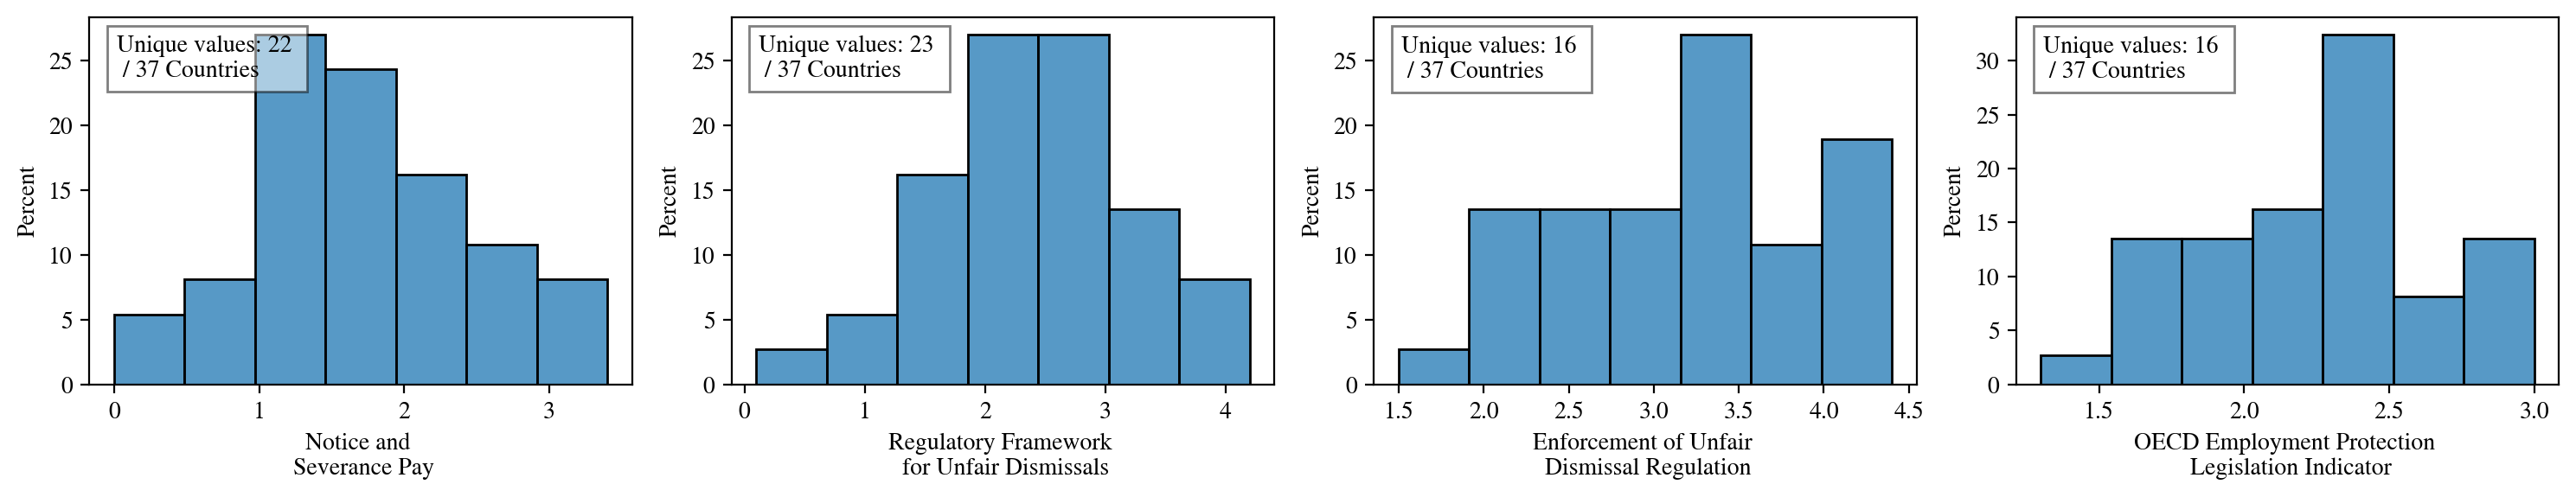

In [14]:
fig, axes = plt.subplots(1, 4, figsize=(15, 3))

for idx, measure in enumerate(oecd_table.columns[2:]):
    ax = axes[idx]
    sns.histplot(oecd_table[measure], stat='percent', ax=ax)
    
    # Get the number of unique values
    n_unique = oecd_table[measure].nunique()
    
    # Add the text to the plot
    ax.text(0.05, 0.95, f'Unique values: {n_unique} \n / 37 Countries',
            transform=ax.transAxes, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

plt.tight_layout()

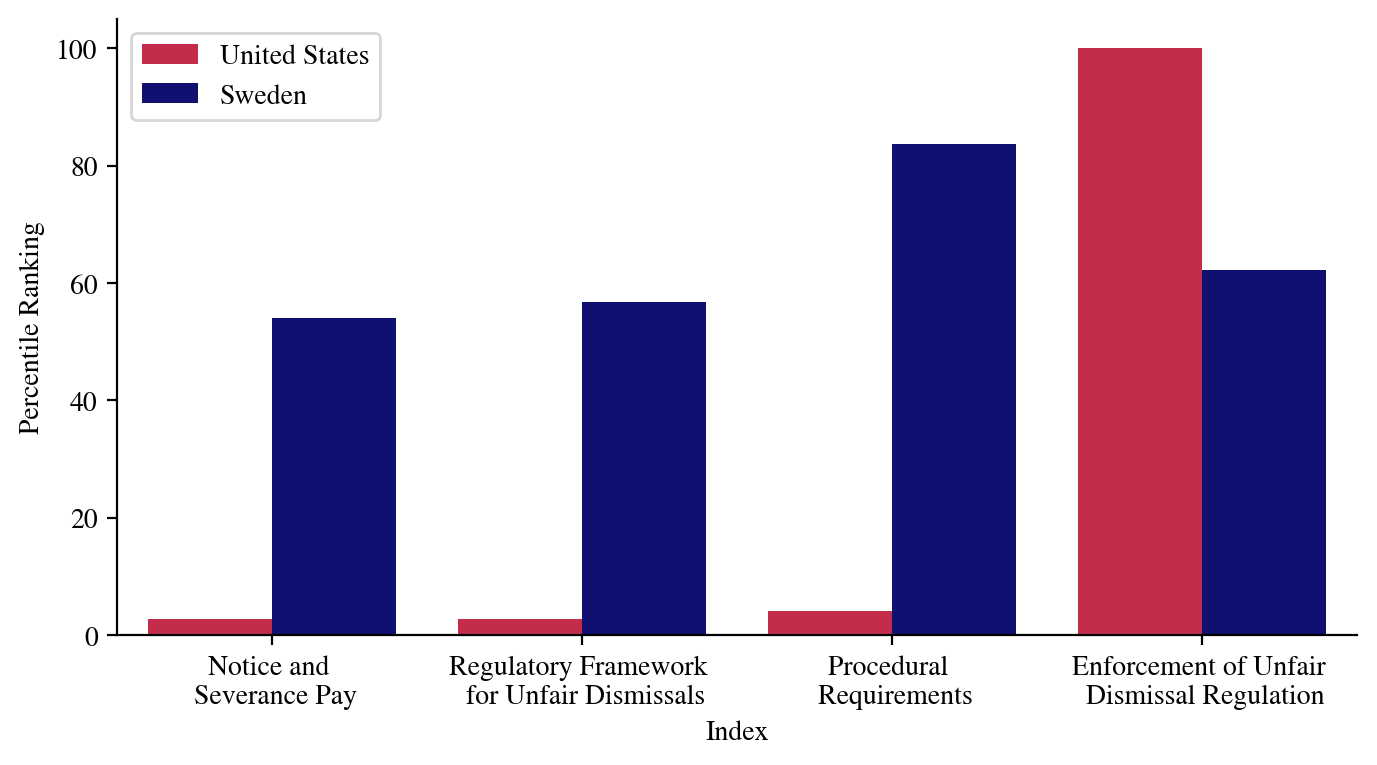

In [15]:
# Calculate the percentiles for each value in the DataFrame
oecd_table_percentiles = oecd_table.copy()
for column in oecd_table_percentiles.columns[1:]:
    oecd_table_percentiles[column] = oecd_table_percentiles[column].rank(pct=True) * 100

# Filter rows for Sweden and the United States
selected_countries_percentiles = oecd_table_percentiles[oecd_table_percentiles["Country"].isin(["Sweden", "United States"])]

# Melt the DataFrame for easier plotting
melted_df = selected_countries_percentiles.melt(id_vars="Country").sort_values(["Country", "value"], ascending=[False, True])
melted_df = melted_df[melted_df["variable"] != 'OECD Employment Protection \n Legislation Indicator']

# Extract the sorted "variable" column to use as x-axis in the barplot
x_order = melted_df[melted_df["Country"] == "United States"]["variable"]

# Create the barplot
plt.figure(figsize=(8, 4))
sns.barplot(data=melted_df, x="variable", y="value", hue="Country", palette=["crimson", "navy"], order=x_order)

# Remove top and right plot borders
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xticks(rotation=0)
plt.xlabel("Index")
plt.ylabel("Percentile Ranking")
plt.legend(title="")
plt.show()

## Part 4: ILO EPL Strictness Indeces

<Figure size 640x480 with 0 Axes>

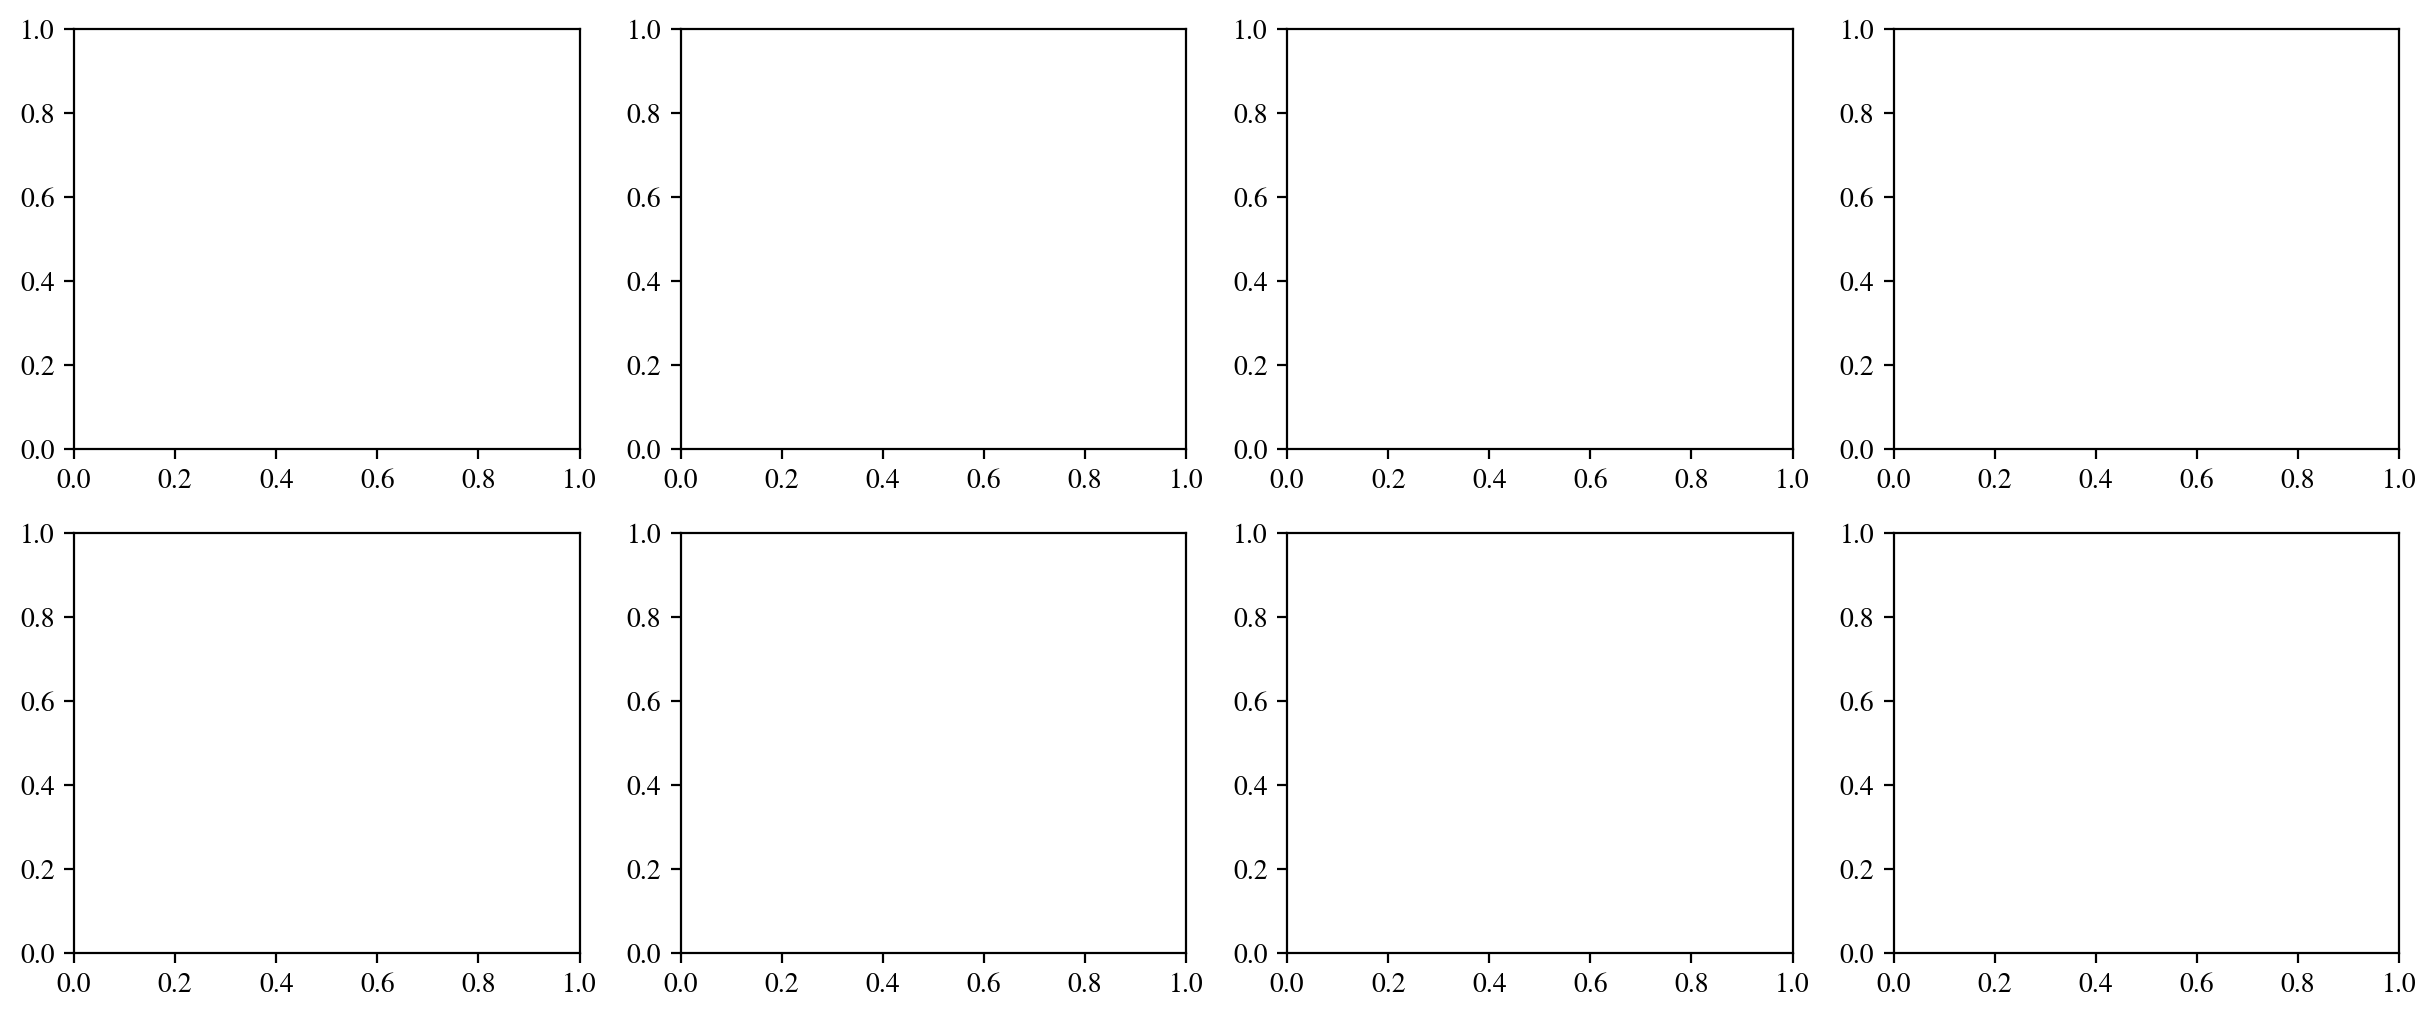

In [16]:
ilo = pd.read_csv(base_path + "epl_ilo.csv")
ilo = ilo[ilo["year"] == 2017] #focusing on most recent year

ilo = ilo[['country', 'EPLEX', 'AREA1_2', 'AREA2', 'AREA3_1', #focusing on relevant indeces
       'AREA3_2', 'AREA4_1', 'AREA4_2', 'AREA5']]
ilo.columns = ["Country", 'Overall Index', 'Prohibited Grounds \n for Dismissals',
               'Max Trial \n Period', "Proceedural Requirements \n for Dismissals", "Notice Periods", "Severance Pay",
               "Redundancy Pay", "Redress"] #labeling indeces with more descriptive names
oecd_country_names = [
    'Australia',
    'Austria',
    'Belgium',
    'Canada',
    'Chile',
    'Czech Republic',
    'Denmark',
    'Estonia',
    'Finland',
    'France',
    'Germany',
    'Greece',
    'Hungary',
    'Iceland',
    'Ireland',
    'Israel',
    'Italy',
    'Japan',
    'Korea',
    'Luxembourg',
    'Mexico',
    'Netherlands',
    'New Zealand',
    'Norway',
    'Poland',
    'Portugal',
    'Slovak Republic',
    'Slovenia',
    'Spain',
    'Sweden',
    'Switzerland',
    'Turkey',
    'United Kingdom',
    'United States',
] # list of ISO codes for OECD countries as of 2019
# renaming countries for merging where necessary
# _W means white collar, _B means blue collar.  
country_dict = {'Austria _B':'Austria', 'Belgium _B':'Belgium', 'Australia 15+':'Australia', 'Greece _B':'Greece',
 'Canada (Federal only)':'Canada', 'Denmark _W':'Denmark', 'Italy 15+':'Italy', 'Portugal 10+':'Portugal',
 'Czechia':'Czech Republic', 'Slovakia':'Slovak Republic', 'Korea, Republic of':'Korea'}
ilo['Country'] = ilo['Country'].apply(lambda x: country_dict[x] if x in country_dict else x)
n_measures = len(ilo.columns[2:])
n_cols = 4
n_rows = math.ceil(n_measures / n_cols)
plt.tight_layout()
ilo = ilo[ilo["Country"].isin(oecd_country_names)].sort_values(by='Overall Index')
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 3))

In [17]:
#missing OECD Countries (as of 2019) in ILO data: 5/34
set(oecd_country_names) - set(ilo["Country"])

{'Canada', 'Iceland', 'Ireland', 'Israel', 'Poland'}

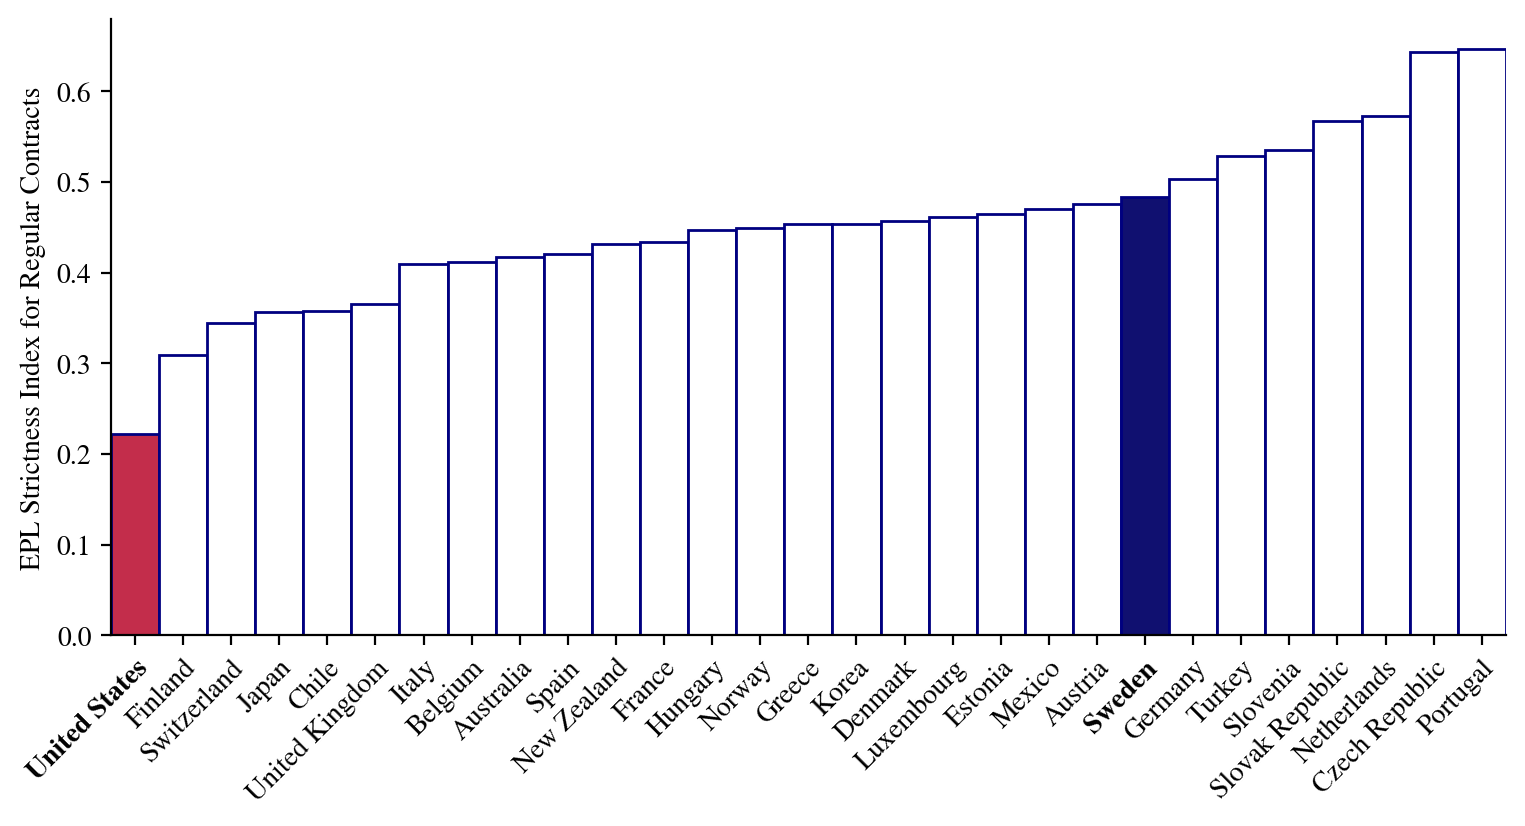

In [18]:
plt.figure(figsize=(9, 4))
ax = sns.barplot(data=ilo, x='Country', y='Overall Index', 
                     palette=['white' if country not in ['United States', 'Sweden'] else 'navy' if country == "Sweden" else "crimson" for country in ilo['Country']],
                     edgecolor='navy', linewidth=1, width=1)

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')

# Make US and Sweden labels bold
bold_labels = ['United States', 'Sweden']
for label in ax.get_xticklabels():
    if label.get_text() in bold_labels:
        label.set_weight('bold')

# Remove top and right plot borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlabel('')
plt.ylabel("EPL Strictness Index for Regular Contracts")
plt.show()

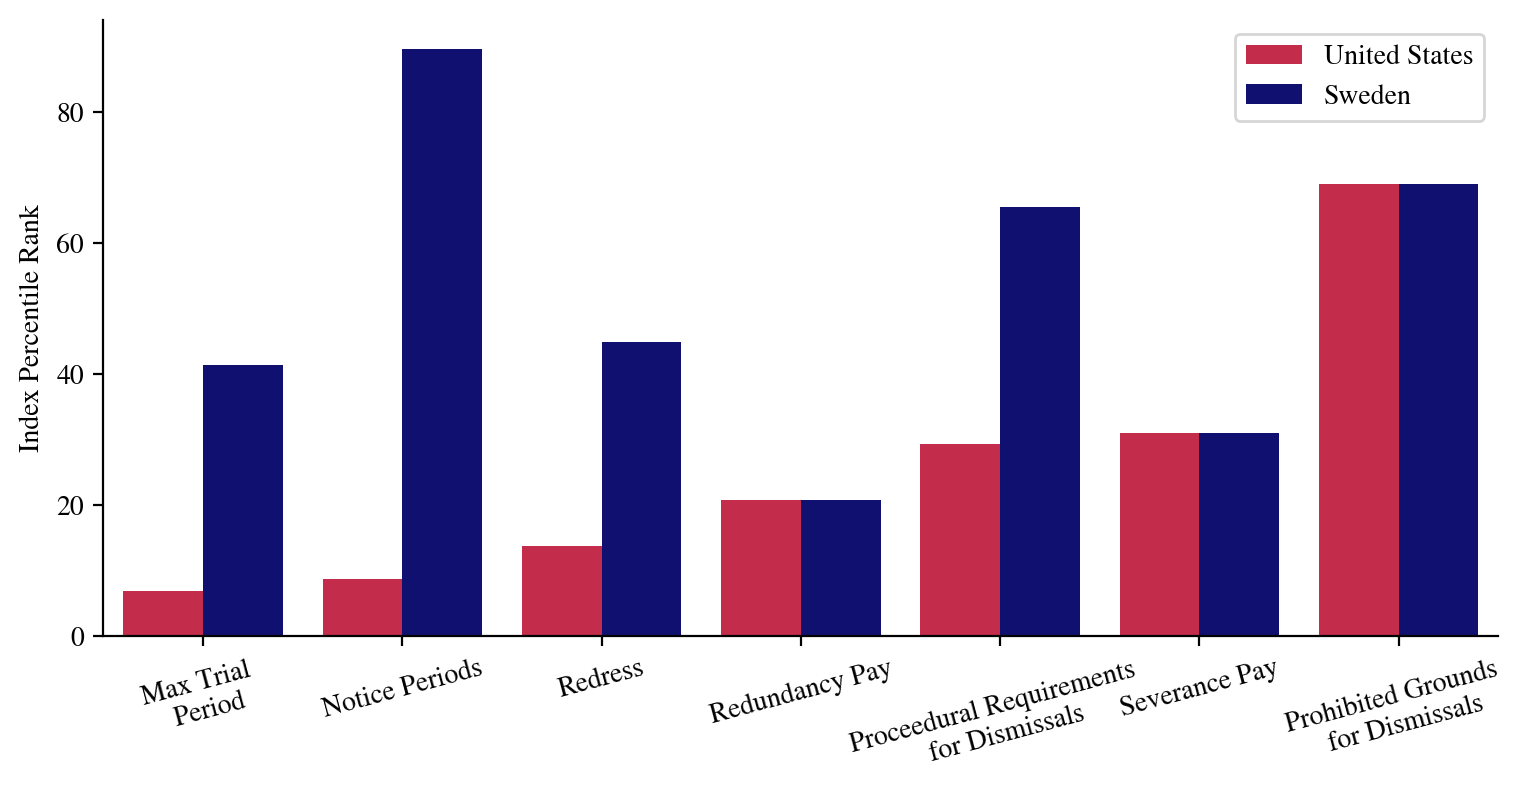

In [19]:
# Calculate the percentiles for each value in the DataFrame
oecd_table_percentiles = ilo.copy()
for column in oecd_table_percentiles.columns[1:]:
    oecd_table_percentiles[column] = oecd_table_percentiles[column].rank(pct=True) * 100

# Filter rows for Sweden and the United States
selected_countries_percentiles = oecd_table_percentiles[oecd_table_percentiles["Country"].isin(["Sweden", "United States"])]

# Melt the DataFrame for easier plotting, sort by "value" column for United States
melted_df = selected_countries_percentiles.melt(id_vars="Country").sort_values(["Country", "value"], ascending=[False, True])
melted_df = melted_df[melted_df["variable"] != "Overall Index"]

# Extract the sorted "variable" column to use as x-axis in the barplot
x_order = melted_df[melted_df["Country"] == "United States"]["variable"]

# Create the barplot
plt.figure(figsize=(9, 4))
sns.barplot(data=melted_df, x="variable", y="value", hue="Country", palette=["crimson", "navy"], order=x_order)

# Remove top and right plot borders
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xticks(rotation=15)
plt.ylabel("Index Percentile Rank")
plt.xlabel("")
plt.legend(title="")
plt.show()


## Part 5: Unemployment Measures and EPL

Unemployment measures used:
- standard measure unemployment from the OECD
- [employment/population ratio
](https://stats.oecd.org/index.aspx?queryid=54742#)
- [longterm unemployment](https://stats.oecd.org/index.aspx?queryid=36324#)
- job finding rate ("outflow rate (f)") and separation rate ("inflow rate (s)") from [this paper](https://dataverse.harvard.edu/file.xhtml?persistentId=doi:10.7910/DVN/4BJC20/LFYZTF)

In [20]:
# Importing unemployment measures
u_rate = pd.read_csv(base_path + "oecd_unemployment_measures.csv")[["LOCATION", "Time", "Value"]]
longterm = pd.read_csv(base_path + "oecd_long_term_unemployment.csv")[["COUNTRY", "Country", "Age", "Time", "Value"]]
flows = pd.read_csv(base_path + "job_inflow_outflow.csv")[["Country", "outflow_rate", "inflow_rate"]]
emp_pop = pd.read_csv(base_path + "emp_pop_ratio.csv")[["COU", "Country", "Time", "Value"]]

# Cleaning data, renaming/removing columns so they match, and filtering data to relevant sample
epl = df[["iso", "country", "year", "measure", "value", "oecd"]].rename(columns={"value":"epl_index"})
u_rate.columns = ["iso", "year", "u"]
longterm = longterm[longterm["Age"] == "Total"]
del longterm["Age"]
longterm.columns = ["iso", "country", "year", "longterm_u"]
emp_pop.columns = ["iso", "country", "year", "emp_pop_ratio"]
flows.columns = ["country", "finding", "separation"]
flows["finding"] = flows["finding"].str[:-1].astype(float)
flows["separation"] = flows["separation"].str[:-1].astype(float)

# Merging data
emp_stats = (epl[epl["country"] != "OECD countries"]
             .merge(longterm, on=["iso", "country", "year"], how="outer")
             .merge(emp_pop, on=["iso", "country", "year"], how="outer")
             .merge(u_rate, on=["iso", "year"], how="outer")
             .merge(flows, on="country", how="outer"))

# Selecting OECD countries
emp_stats = emp_stats[emp_stats["oecd"] == True]
del emp_stats["oecd"]
emp_stats["year"] = emp_stats["year"].astype(int)
emp_stats["tot_longterm_u"] = emp_stats["longterm_u"] * emp_stats["u"] / 100

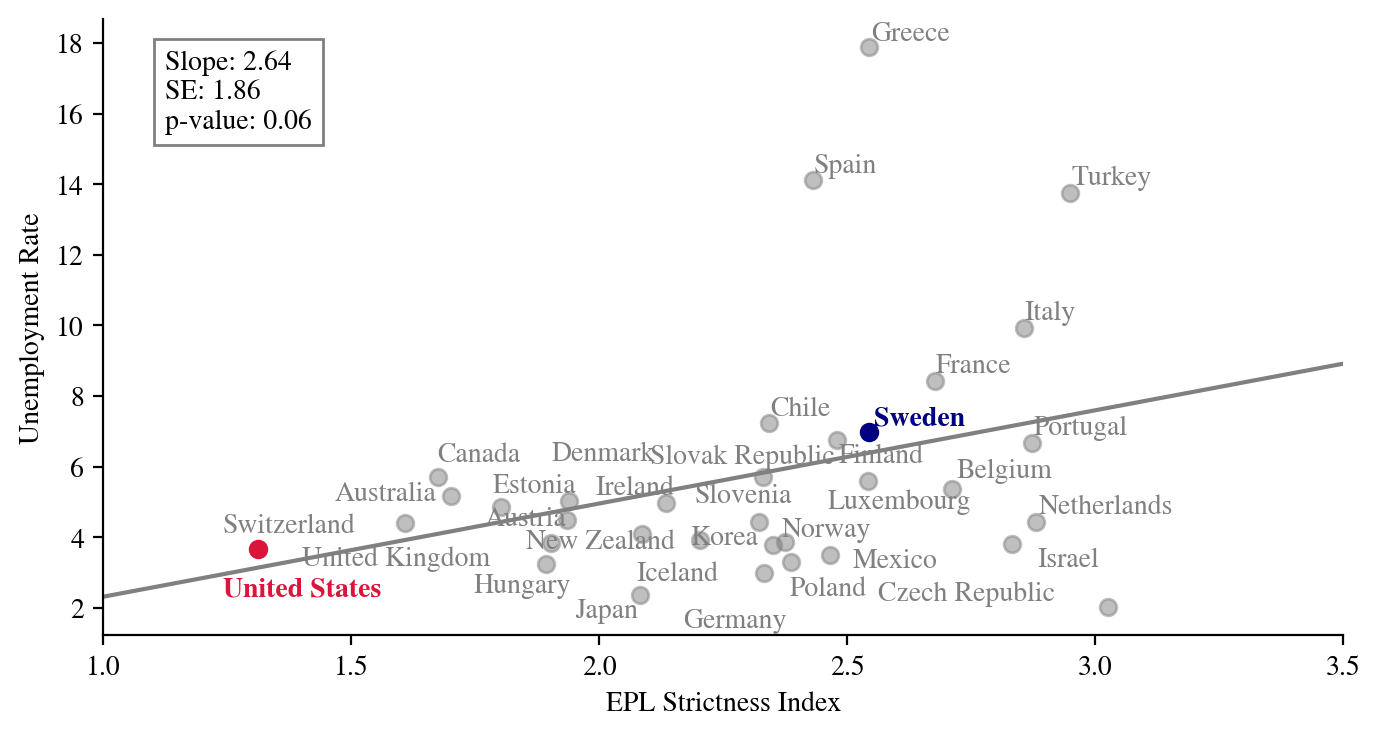

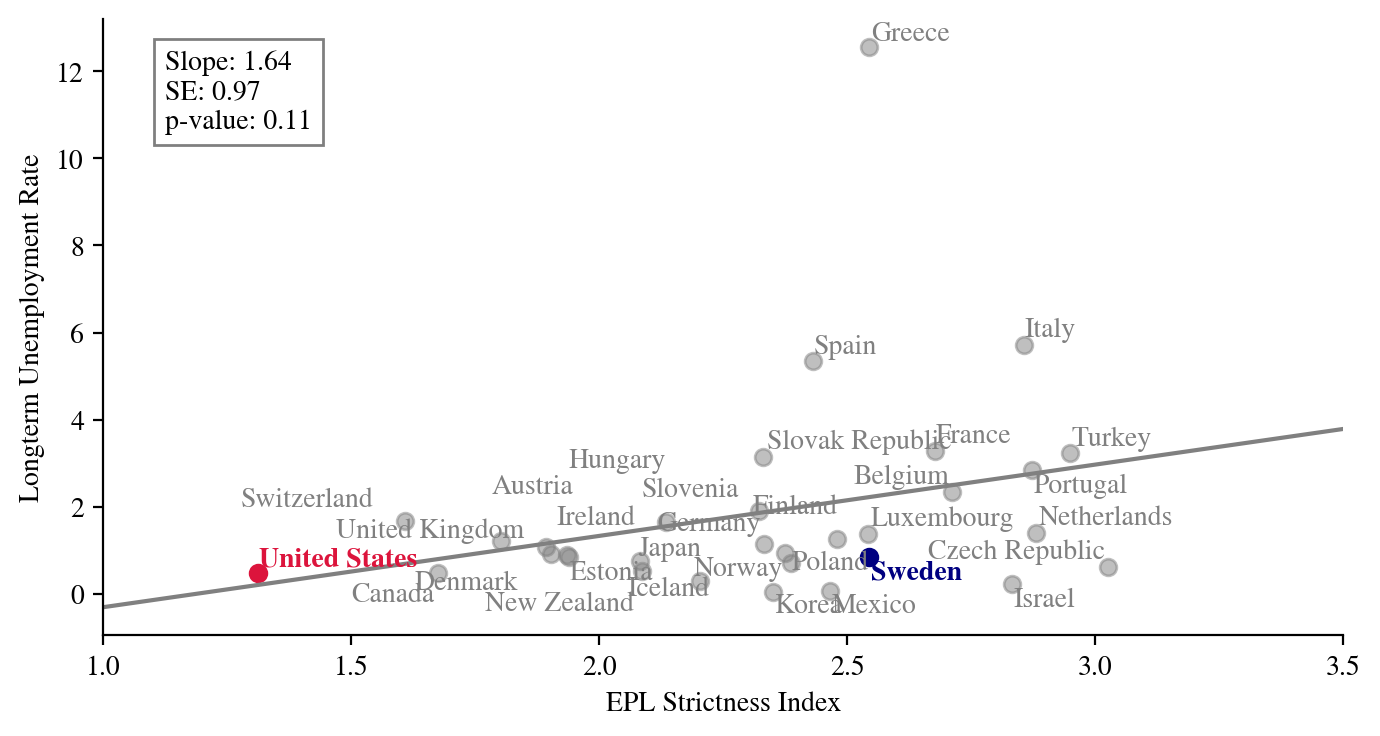

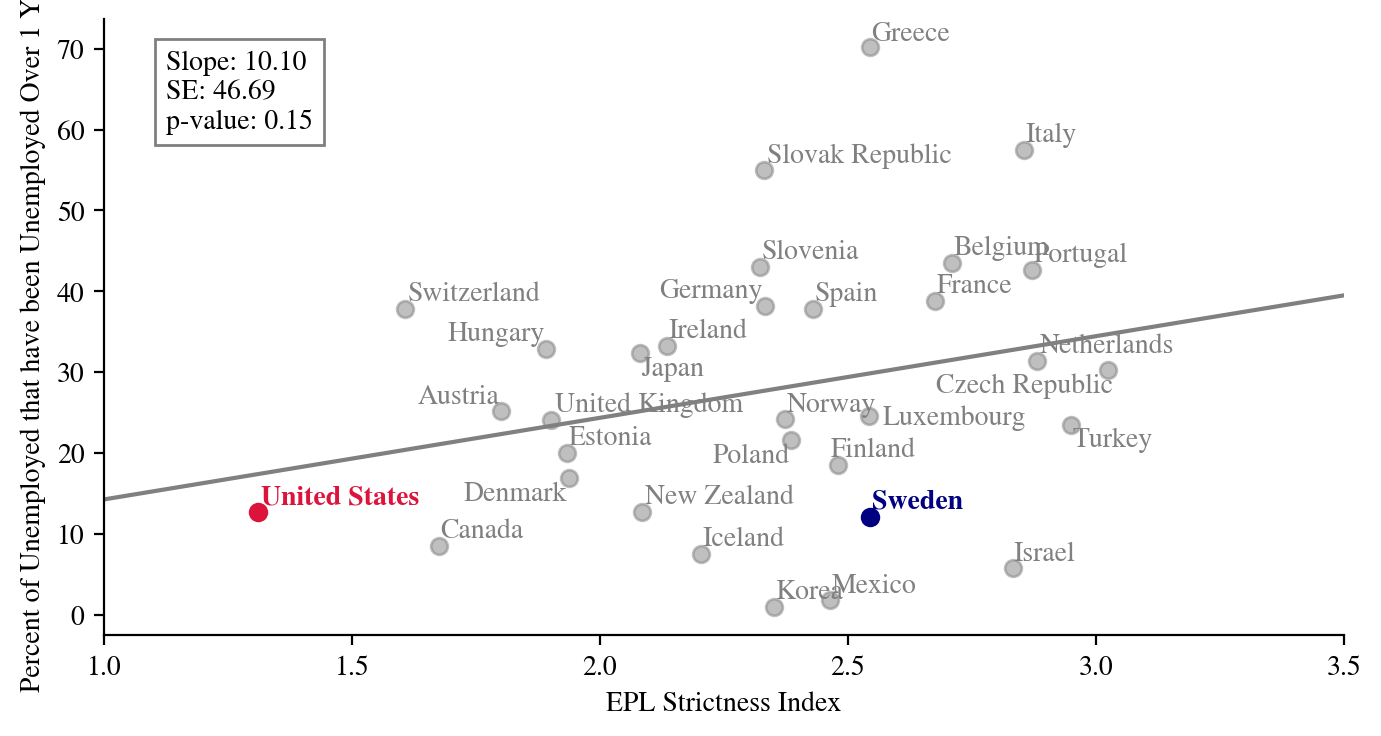

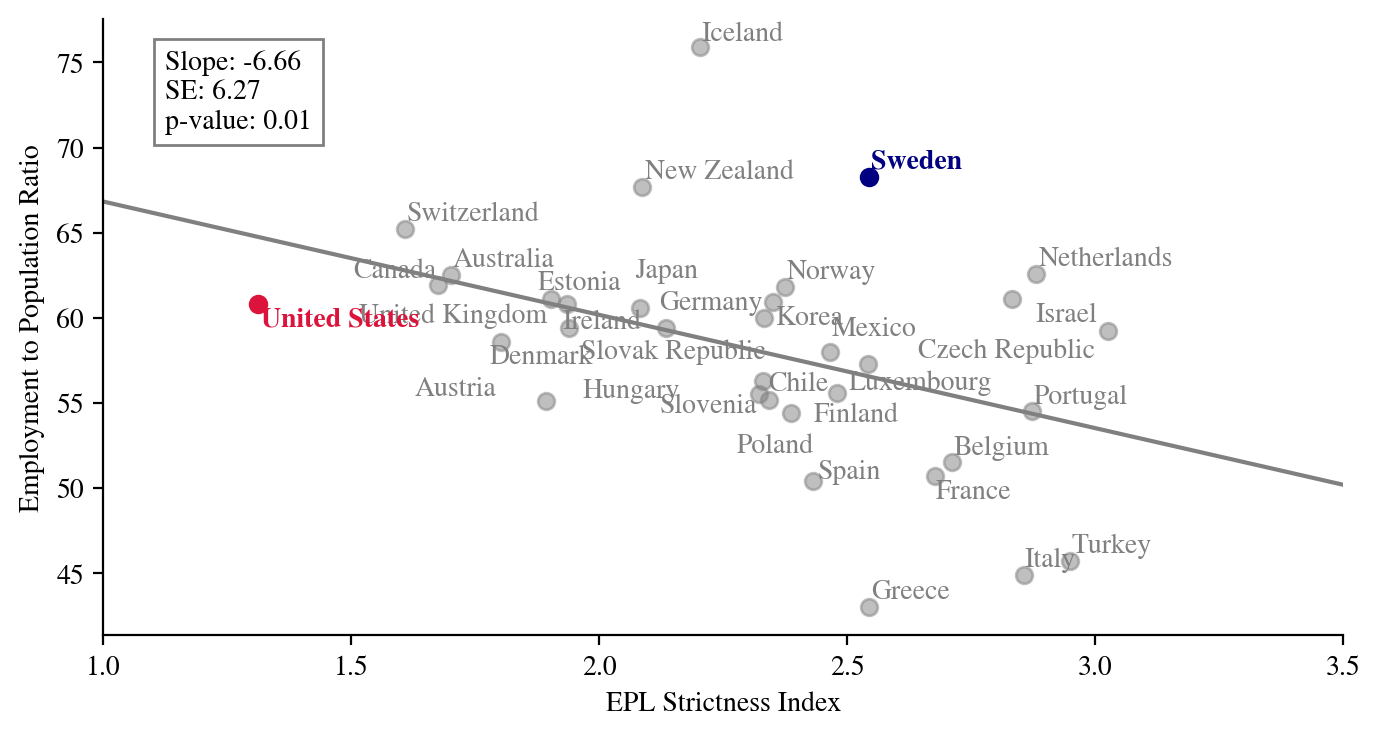

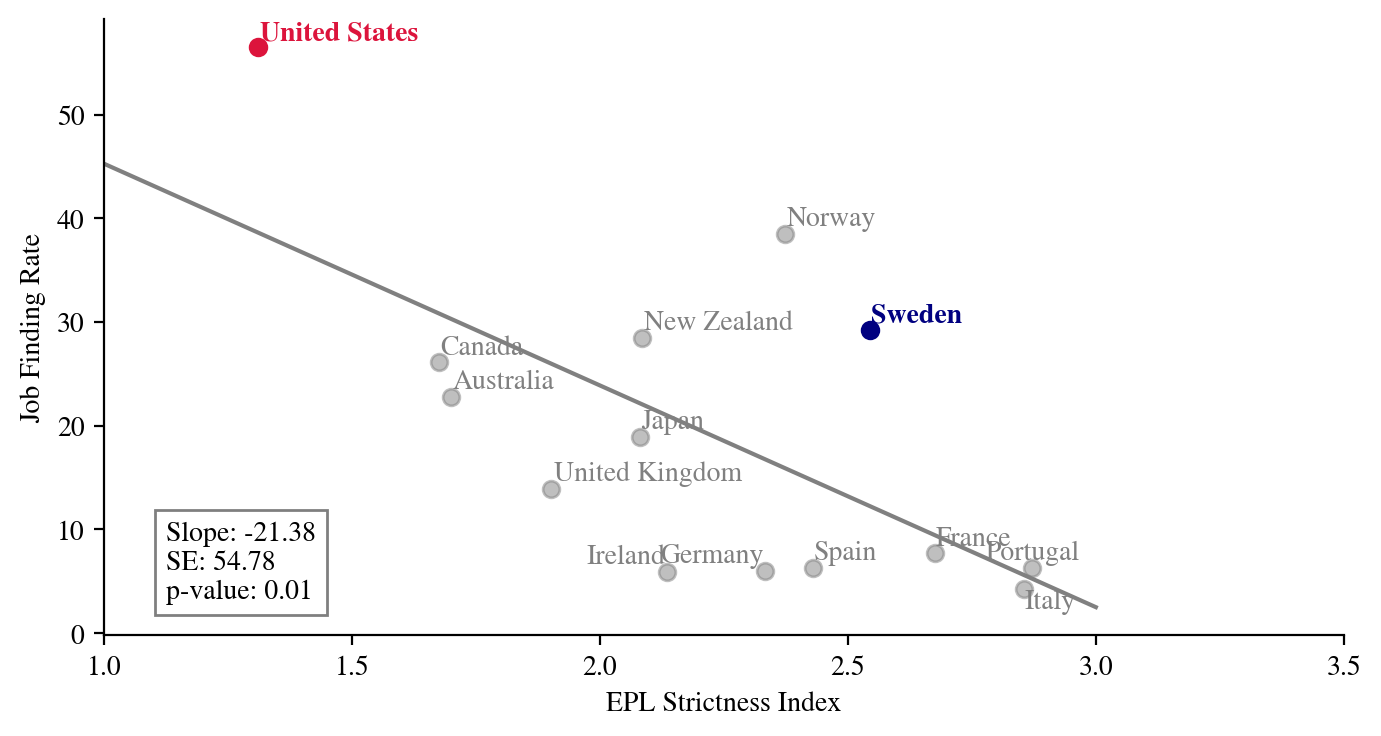

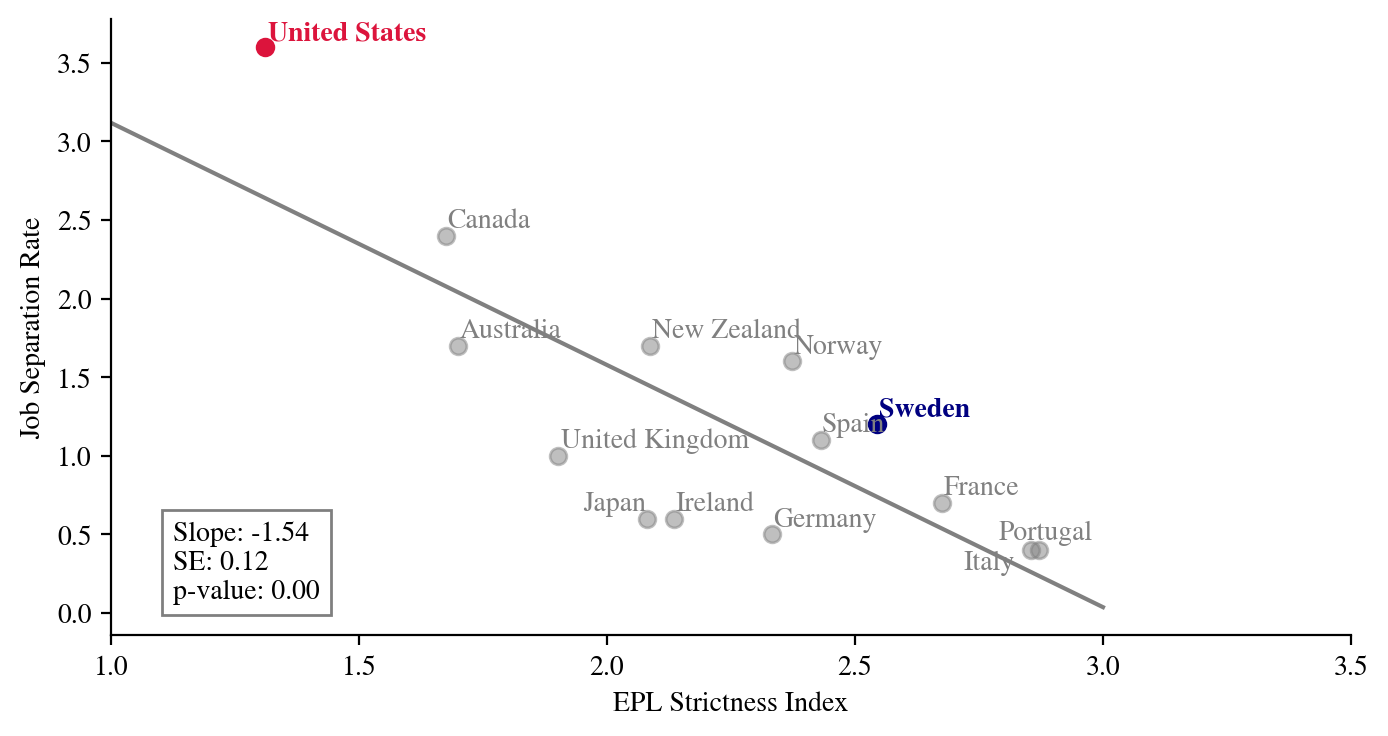

In [21]:
var_full_names = {
    'u': 'Unemployment Rate',
    'longterm_u': 'Percent of Unemployed that have been Unemployed Over 1 Year',
    'emp_pop_ratio': 'Employment to Population Ratio',
    'finding': 'Job Finding Rate',
    'separation': 'Job Separation Rate',
    'epl_index': "EPL Strictness Index",
    'tot_longterm_u': "Longterm Unemployment Rate"}

dot_colors = {
    'United States': 'crimson',
    'Sweden': 'navy',
    'Turkey': 'grey'}

for country in emp_stats['country'].unique():
    if country not in dot_colors.keys():
        dot_colors[country] = 'grey'

year = 2019
x_var = "epl_index"
variables = ['u', 'tot_longterm_u', 'longterm_u', 'emp_pop_ratio', 'finding', 'separation']  # Specify measures to plot
year_df = emp_stats[(emp_stats['year'] == year) & (emp_stats["measure"] == "EPRC_V4")]


for var in variables:
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 4)

    # Scatter plot of the data
    for i, row in year_df.iterrows():
        country = row['country']
        color = dot_colors[country]
        if np.isfinite(row[x_var]) and np.isfinite(row[var]):
            alpha_val = 0.5 if country not in ['United States', 'Sweden'] else 1
            ax.scatter(row[x_var], row[var], color=color, alpha=alpha_val)
    
    # Adding text labels for the dots
    texts = []
    for i, txt in enumerate(year_df['country']):
        if np.isfinite(year_df[x_var].iloc[i]) and np.isfinite(year_df[var].iloc[i]):
            if txt == "Türkiye":
                txt = "Turkey"
            weight_val = 'bold' if txt in ['United States', 'Sweden'] else 'normal'
            texts.append(ax.text(year_df[x_var].iloc[i], year_df[var].iloc[i], txt, color=dot_colors[txt], weight = weight_val))
    adjust_text(texts)  # Prevent overlapping country names

    # Fit a linear regression line only for finite values
    finite_mask = np.isfinite(year_df[x_var]) & np.isfinite(year_df[var])
    finite_data = year_df[finite_mask]
    if len(finite_data) > 0:
        slope, intercept, r_value, p_value, se = linregress(finite_data[x_var], finite_data[var])
        x_range = np.linspace(int(min(finite_data[x_var])), int(max(finite_data[x_var])) + 1, num=100)
        ax.plot(x_range, [slope * x + intercept for x in x_range], 'grey')
        ax.set_xlabel(var_full_names[x_var])
        ax.set_ylabel(var_full_names[var])
        plt.xlim(1, 3.5)

        # Report the slope, SE, and p-value on the graph
        if var in ['finding', 'separation']:
            ax.text(0.05, 0.05, f'Slope: {slope:.2f}\nSE: {se**2:.2f}\np-value: {p_value:.2f}',
                    transform=ax.transAxes, verticalalignment='bottom', bbox=dict(facecolor='white', alpha=0.5))
        else:
            ax.text(0.05, 0.95, f'Slope: {slope:.2f}\nSE: {se**2:.2f}\np-value: {p_value:.2f}',
                    transform=ax.transAxes, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

        #remove the top and right spines    
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    plt.show()

## Old Code and Plots to Ignore

In [22]:
"""years = [1990, 2010, 2019]  # Years to look into
versions = ["EPRC_V1", "EPRC_V3", "EPRC_V4"] # Most recent versions of indeces available for each year
year_to_measure = dict(zip(years, versions)) # Maps each year to the most recent index available that year

# Defining a set of "core countries" that have data for all relevant time periods and measures
core_countries = emp_stats[(emp_stats["year"] == 1990) 
    & (emp_stats["separation"].notna()) 
    & (emp_stats["longterm_u"].notna())
    & (emp_stats["emp_pop_ratio"].notna())
    & (emp_stats["u"].notna())]["country"].unique()


variables = ['u', 'longterm_u', 'emp_pop_ratio', 'finding', 'separation']  # Specify measures to plot
x_var = 'epl_index' 
"""

'years = [1990, 2010, 2019]  # Years to look into\nversions = ["EPRC_V1", "EPRC_V3", "EPRC_V4"] # Most recent versions of indeces available for each year\nyear_to_measure = dict(zip(years, versions)) # Maps each year to the most recent index available that year\n\n# Defining a set of "core countries" that have data for all relevant time periods and measures\ncore_countries = emp_stats[(emp_stats["year"] == 1990) \n    & (emp_stats["separation"].notna()) \n    & (emp_stats["longterm_u"].notna())\n    & (emp_stats["emp_pop_ratio"].notna())\n    & (emp_stats["u"].notna())]["country"].unique()\n\n\nvariables = [\'u\', \'longterm_u\', \'emp_pop_ratio\', \'finding\', \'separation\']  # Specify measures to plot\nx_var = \'epl_index\' \n'

In [23]:
"""fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(20, 25)) # Creating grid to display plots in

for row, var in enumerate(variables):
    for col, year in enumerate(years):
        ax = axes[row, col]
        year_df = emp_stats[(emp_stats['year'] == year) & (emp_stats["measure"] == year_to_measure[year])]
        #year_df = year_df[year_df["country"].isin(core_countries)] # Uncopmment to limit analysis to core countries
        
        if not year_df.empty:
            ax.scatter(year_df[x_var], year_df[var])

            texts = []
            for i, txt in enumerate(year_df['country']):
                if np.isfinite(year_df[x_var].iloc[i]) and np.isfinite(year_df[var].iloc[i]):
                    texts.append(ax.text(year_df[x_var].iloc[i], year_df[var].iloc[i], txt))

            adjust_text(texts, ax=ax)  # Prevent overlapping country names

            # Fit a linear regression line only for finite values
            finite_mask = np.isfinite(year_df[x_var]) & np.isfinite(year_df[var])
            finite_data = year_df[finite_mask]
            if len(finite_data) > 0:
                slope, intercept, r_value, p_value, _ = linregress(finite_data[x_var], finite_data[var])
                x_range = np.linspace(int(min(finite_data[x_var])), int(max(finite_data[x_var])) + 1, num=100)
                ax.plot(x_range, [slope * x + intercept for x in x_range], 'grey', label='Fitted Line')

                ax.set_title(f'{year} {var_full_names[var]} vs {var_full_names[x_var]}')
                ax.set_xlabel(var_full_names[x_var])
                ax.set_ylabel(var_full_names[var])
                plt.legend()

                # Report the slope, R^2, and p-value on the graph
                ax.text(0.05, 0.95, f'Slope: {slope:.2f}\nR^2: {r_value**2:.2f}\np-value: {p_value:.2f}',
                        transform=ax.transAxes, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

plt.tight_layout()
plt.show()"""

'fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(20, 25)) # Creating grid to display plots in\n\nfor row, var in enumerate(variables):\n    for col, year in enumerate(years):\n        ax = axes[row, col]\n        year_df = emp_stats[(emp_stats[\'year\'] == year) & (emp_stats["measure"] == year_to_measure[year])]\n        #year_df = year_df[year_df["country"].isin(core_countries)] # Uncopmment to limit analysis to core countries\n        \n        if not year_df.empty:\n            ax.scatter(year_df[x_var], year_df[var])\n\n            texts = []\n            for i, txt in enumerate(year_df[\'country\']):\n                if np.isfinite(year_df[x_var].iloc[i]) and np.isfinite(year_df[var].iloc[i]):\n                    texts.append(ax.text(year_df[x_var].iloc[i], year_df[var].iloc[i], txt))\n\n            adjust_text(texts, ax=ax)  # Prevent overlapping country names\n\n            # Fit a linear regression line only for finite values\n            finite_mask = np.isfinite(year_df[